# **MLP with extended physics loss function (Option 1: with PDEs numeric approximation)**


## **Running the models using the 'modelling' package**

A notebook through which different modelling configurations can be ran, using the ``modelling`` package. It follows the steps of:
- preparing packages;
- setting "global" variables;
- getting the data;
- defining hyperparameters;
- running a grid search and/or training a model; and
- evaluation.
In the modelling package, variations can be made to the models and training functions to experiment. Don't forget to restart the notebook after making changes there.



For loading models, go to the ``src/results/models``:
- Baseline NO2 2017 with MLP and MSE loss: ``best_mlp_no2_baseline.pth``
- Exp 1: NO2 2017 with MLP and option 1 simple physics loss: ``best_mlp_no2_adjusted_dist.pth`` (naming because I updated the distance between T and B)


In [1]:
print("Starting script...")


from modelling.MLP import BasicMLP
from modelling import *


import optuna
import threading
import os
from pathlib import Path
import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

Starting script...

Running __init__.py for data pipeline...
Modelling package initialized



Use GPU when available

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cpu


### **Set "global" variables**

In [3]:
Path.cwd()

PosixPath('/home/rachel/forecasting_smog_PEML/src')

In [4]:
HABROK = bool(0)                  # set to True if using HABROK; it will print
                                  # all stdout to a .txt file to log progress

BASE_DIR = Path.cwd().parents[0] # set it to the root directory of the project, not src
MODEL_PATH = BASE_DIR /"src" / "results" / "models"
MINMAX_PATH = BASE_DIR  / "data" / "data_combined" / "pollutants_minmax.csv"

print("BASE_DIR: ", BASE_DIR)
print("MODEL_PATH: ", MODEL_PATH)
print("MINMAX_PATH: ", MINMAX_PATH)

torch.manual_seed(34)             # set seed for reproducibility

N_HOURS_U = 24 * 3               # number of hours to use for input (number of days * 24 hours)
N_HOURS_Y = 24                    # number of hours to predict (1 day * 24 hours)
N_HOURS_STEP = 24                 # "sampling rate" in hours of the data; e.g. 24 
                                  # means sample an I/O-pair every 24 hours
                                  # the contaminants and meteorological vars

# Change this according to the data you want to use
YEARS = [2017]
TRAIN_YEARS = [2017]
VAL_YEARS = [2017]
TEST_YEARS = [2017]

LOSS_FUNC = "Physics_PDE" # choose from "MSE" and "Physics_Linear_MSE" and "Physics_PDE"

BASE_DIR:  /home/rachel/forecasting_smog_PEML
MODEL_PATH:  /home/rachel/forecasting_smog_PEML/src/results/models
MINMAX_PATH:  /home/rachel/forecasting_smog_PEML/data/data_combined/pollutants_minmax.csv


### **Load in data and create PyTorch *Datasets***

In [5]:
# Load in data and create PyTorch Datasets. To tune
# which exact .csv files get extracted, change the
# lists in the get_dataframes() definition

train_input_frames = get_dataframes('train', 'u', YEARS)
train_output_frames = get_dataframes('train', 'y', YEARS)

val_input_frames = get_dataframes('val', 'u', YEARS)
val_output_frames = get_dataframes('val', 'y', YEARS)

test_input_frames = get_dataframes('test', 'u', YEARS)
test_output_frames = get_dataframes('test', 'y', YEARS) 

print("Successfully loaded data")

Imported train_2017_combined_u.csv
Imported train_2017_combined_y.csv
Imported val_2017_combined_u.csv
Imported val_2017_combined_y.csv
Imported test_2017_combined_u.csv
Imported test_2017_combined_y.csv
Successfully loaded data


In [6]:
train_dataset = TimeSeriesDataset(
    train_input_frames,  # list of input training dataframes
    train_output_frames, # list of output training dataframes
    len(TRAIN_YEARS),                   # number of dataframes put in for both
                         # (basically len(train_input_frames) and
                         # len(train_output_frames) must be equal)
    N_HOURS_U,           # number of hours of input data
    N_HOURS_Y,           # number of hours of output data
    N_HOURS_STEP,        # number of hours between each input/output pair
)
val_dataset = TimeSeriesDataset(
    val_input_frames,    # etc.
    val_output_frames,
    len(VAL_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)
test_dataset = TimeSeriesDataset(
    test_input_frames,
    test_output_frames,
    len(TEST_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)

del train_input_frames, train_output_frames
del val_input_frames, val_output_frames
del test_input_frames, test_output_frames

In [7]:
train_dataset.u

[                           DD   FF        FH        FX       NO2         P  \
 DateTime                                                                     
 2017-08-01 00:00:00  0.166667  0.1  0.111111  0.000000  0.242115  0.562982   
 2017-08-01 01:00:00  0.000000  0.0  0.111111  0.052632  0.223158  0.570694   
 2017-08-01 02:00:00  0.000000  0.0  0.000000  0.000000  0.165911  0.560411   
 2017-08-01 03:00:00  0.277778  0.1  0.000000  0.000000  0.142363  0.555270   
 2017-08-01 04:00:00  0.805556  0.2  0.111111  0.105263  0.156297  0.555270   
 ...                       ...  ...       ...       ...       ...       ...   
 2017-11-16 19:00:00  0.750000  0.2  0.333333  0.210526  0.523871  0.789203   
 2017-11-16 20:00:00  0.972222  0.3  0.333333  0.421053  0.512314  0.814910   
 2017-11-16 21:00:00  0.888889  0.1  0.222222  0.263158  0.232880  0.827763   
 2017-11-16 22:00:00  0.944444  0.2  0.111111  0.105263  0.108123  0.832905   
 2017-11-16 23:00:00  0.861111  0.1  0.222222  0.105

In [8]:
train_dataset.y

[                          NO2
 DateTime                     
 2017-08-01 00:00:00  0.223698
 2017-08-01 01:00:00  0.145496
 2017-08-01 02:00:00  0.275978
 2017-08-01 03:00:00  0.423742
 2017-08-01 04:00:00  0.478721
 ...                       ...
 2017-11-16 19:00:00  0.606502
 2017-11-16 20:00:00  0.456470
 2017-11-16 21:00:00  0.483258
 2017-11-16 22:00:00  0.468784
 2017-11-16 23:00:00  0.473428
 
 [2592 rows x 1 columns]]

In [9]:
len(train_dataset.pairs[0][0])

72

In [10]:
train_dataset.pairs[0][0]

tensor([[0.1667, 0.1000, 0.1111, 0.0000, 0.2421, 0.5630, 0.0000, 0.5367, 0.7269],
        [0.0000, 0.0000, 0.1111, 0.0526, 0.2232, 0.5707, 0.0000, 0.5467, 0.7407],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1659, 0.5604, 0.0000, 0.5067, 0.6898],
        [0.2778, 0.1000, 0.0000, 0.0000, 0.1424, 0.5553, 0.0000, 0.4633, 0.6343],
        [0.8056, 0.2000, 0.1111, 0.1053, 0.1563, 0.5553, 0.0000, 0.4933, 0.6620],
        [0.0000, 0.0000, 0.1111, 0.1053, 0.3135, 0.5681, 0.3000, 0.6200, 0.7593],
        [0.7222, 0.1000, 0.1111, 0.0526, 0.5326, 0.5913, 0.0000, 0.6433, 0.7269],
        [0.7500, 0.1000, 0.1111, 0.1053, 0.5367, 0.5938, 0.0000, 0.6500, 0.7037],
        [0.7222, 0.2000, 0.2222, 0.1053, 0.5172, 0.5964, 0.0000, 0.6733, 0.6574],
        [0.7500, 0.2000, 0.2222, 0.2105, 0.4459, 0.5990, 0.3000, 0.7133, 0.6157],
        [0.6111, 0.2000, 0.2222, 0.1579, 0.3129, 0.6041, 0.0000, 0.7167, 0.6019],
        [0.6111, 0.2000, 0.2222, 0.1579, 0.3478, 0.6067, 0.0000, 0.7133, 0.5926],
        [0.6528,

In [11]:
train_dataset.pairs[0][1]

tensor([[0.1965],
        [0.1501],
        [0.1518],
        [0.2622],
        [0.5524],
        [0.4840],
        [0.3544],
        [0.2754],
        [0.1948],
        [0.1734],
        [0.1505],
        [0.1352],
        [0.0778],
        [0.1184],
        [0.1293],
        [0.1238],
        [0.1043],
        [0.0997],
        [0.0812],
        [0.0823],
        [0.1155],
        [0.0837],
        [0.0570],
        [0.1006]])

In [12]:
# Assuming train_dataset.u[0] is a pandas Index object with column names
column_names = list(train_dataset.u[0])  # Convert Index to list

# Now, find the indices of the columns 'NO2', 'DD', 'FH'
no2_idx = column_names.index('NO2')
dd_idx = column_names.index('DD')
fh_idx = column_names.index('FH')

print("NO2 index: ", no2_idx)
print("DD index (wind direction): ", dd_idx)
print("FH index (Hourly wind speed): ", fh_idx)


NO2 index:  4
DD index (wind direction):  0
FH index (Hourly wind speed):  2


In [13]:
train_dataset.u[0].iloc[:,no2_idx]

DateTime
2017-08-01 00:00:00    0.242115
2017-08-01 01:00:00    0.223158
2017-08-01 02:00:00    0.165911
2017-08-01 03:00:00    0.142363
2017-08-01 04:00:00    0.156297
                         ...   
2017-11-16 19:00:00    0.523871
2017-11-16 20:00:00    0.512314
2017-11-16 21:00:00    0.232880
2017-11-16 22:00:00    0.108123
2017-11-16 23:00:00    0.205120
Name: NO2, Length: 2592, dtype: float64

In [14]:
train_dataset.u[0].iloc[:,dd_idx]

DateTime
2017-08-01 00:00:00    0.166667
2017-08-01 01:00:00    0.000000
2017-08-01 02:00:00    0.000000
2017-08-01 03:00:00    0.277778
2017-08-01 04:00:00    0.805556
                         ...   
2017-11-16 19:00:00    0.750000
2017-11-16 20:00:00    0.972222
2017-11-16 21:00:00    0.888889
2017-11-16 22:00:00    0.944444
2017-11-16 23:00:00    0.861111
Name: DD, Length: 2592, dtype: float64

In [15]:
train_dataset.u[0].iloc[:,fh_idx]

DateTime
2017-08-01 00:00:00    0.111111
2017-08-01 01:00:00    0.111111
2017-08-01 02:00:00    0.000000
2017-08-01 03:00:00    0.000000
2017-08-01 04:00:00    0.111111
                         ...   
2017-11-16 19:00:00    0.333333
2017-11-16 20:00:00    0.333333
2017-11-16 21:00:00    0.222222
2017-11-16 22:00:00    0.111111
2017-11-16 23:00:00    0.222222
Name: FH, Length: 2592, dtype: float64

## **Computing y with the y_phy**

In [16]:
# import matplotlib.pyplot as plt
# # Define basic training
# # Create train & validation loaders (following the original code)
# n_hidden_layers = 2
# n_hidden_units = 64
# batch_size = 32
# lr = 1e-5
# weight_decay = 1e-4

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# # Initialize MLP model
# model = BasicMLP(
#     N_INPUT_UNITS=train_dataset.__n_features_in__(),
#     N_HIDDEN_LAYERS=n_hidden_layers,
#     N_HIDDEN_UNITS=n_hidden_units,
#     N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
#     loss_function=LOSS_FUNC,
# )

# # After training, we can plot y_phy vs y_pred for both training and validation data
# _, train_losses, val_losses, all_y_phy_train, all_y_pred_train, all_y_phy_val, all_y_pred_val = model.train_model(train_loader, val_loader, epochs=50, lr=lr, weight_decay=weight_decay, device=device)

# # Plot Training Loss vs Validation Loss
# epochs = range(1, len(train_losses) + 1)
# plt.figure(figsize=(8, 6))
# plt.plot(epochs, train_losses, label="Train Loss", color="blue", linestyle="-")
# plt.plot(epochs, val_losses, label="Validation Loss", color="red", linestyle="--")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("Training vs Validation Loss")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot y_phy vs y_pred for training data
# plt.figure(figsize=(8, 6))
# plt.scatter(all_y_phy_train, all_y_pred_train, label="Train", alpha=0.5, color="blue")
# plt.xlabel("y_phy (True Values)")
# plt.ylabel("y_pred (Predicted Values)")
# plt.title("Training Data: y_phy vs y_pred")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot y_phy vs y_pred for validation data
# plt.figure(figsize=(8, 6))
# plt.scatter(all_y_phy_val, all_y_pred_val, label="Validation", alpha=0.5, color="red")
# plt.xlabel("y_phy (True Values)")
# plt.ylabel("y_pred (Predicted Values)")
# plt.title("Validation Data: y_phy vs y_pred")
# plt.legend()
# plt.grid(True)
# plt.show()
    

In [17]:
# # Create the DataLoader for the test dataset
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Evaluate the model on the test dataset
# df_minmax = pd.read_csv(MINMAX_PATH, sep=';')
# min_value = df_minmax["min"].values
# max_value = df_minmax["max"].values
# mse, rmse_val, smape_val = model.test_model(test_loader, min_value=min_value, max_value=max_value, device="cpu")

In [18]:
# import torch
# import matplotlib.pyplot as plt

# # Ensure the model is in evaluation mode
# model.eval()

# y_preds = []
# y_trues = []

# # Iterate through the test set and collect predictions & ground truth
# with torch.no_grad():
#     for batch in test_loader:
#         x_test, y_true = batch  # Get input and ground truth
#         x_test = x_test.to("cpu")  # Ensure data is on CPU if needed

#         # Get predictions
#         y_pred = model(x_test)

#         # Store results
#         y_preds.append(y_pred.cpu())
#         y_trues.append(y_true.cpu())

# # Convert lists to tensors
# y_preds = torch.cat(y_preds, dim=0).numpy()
# y_trues = torch.cat(y_trues, dim=0).numpy()

# # Plot results
# plt.figure(figsize=(10, 5))
# plt.plot(y_trues.flatten(), label="Ground Truth (NO₂)", linestyle="-", color="blue")
# plt.scatter(range(len(y_preds.flatten())), y_preds.flatten(), label="Predictions", color="black", s=10)

# plt.xlabel("Time Step")
# plt.ylabel("NO₂ Level")
# plt.title("Predictions vs. Ground Truth")
# plt.legend()
# plt.show()


### **Start hyperparameter searching with Optuna**

In [19]:
def objective(trial):
    # Define hyperparameters to search over
    n_hidden_layers = trial.suggest_int("n_hidden_layers", 1, 5)
    n_hidden_units = trial.suggest_int("n_hidden_units", 32, 256)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-3)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])  # Match the original hp['batch_sz']
    lambda_phy = trial.suggest_loguniform("lambda_phy", 1e-5, 1e-1)

    # Create train & validation loaders (following the original code)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize MLP model
    model = BasicMLP(
        N_INPUT_UNITS=train_dataset.__n_features_in__(),
        N_HIDDEN_LAYERS=n_hidden_layers,
        N_HIDDEN_UNITS=n_hidden_units,
        N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
        loss_function=LOSS_FUNC,
    )

    # Train and return validation loss
    val_loss = model.train_model(train_loader, val_loader, epochs=50, lr=lr, weight_decay=weight_decay, lambda_phy = lambda_phy, device=device)
    
    return val_loss


# Run Optuna optimization
study = optuna.create_study(direction="minimize", study_name="mlp_hyperparameter_optimization_phy_pde2", storage="sqlite:///mlp_hyperparameter_optimization_phy_pde.db", load_if_exists=True)

study.optimize(objective, n_trials=100)

# Print best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)




[I 2025-03-12 17:33:22,228] A new study created in RDB with name: mlp_hyperparameter_optimization_phy_pde2
/tmp/ipykernel_1569/3982845962.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
/tmp/ipykernel_1569/3982845962.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-3)
/tmp/ipykernel_1569/3982845962.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_phy = trial.suggest_loguniform("lambda

Epoch 1/50
Phy loss tensor(0.3294, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0834, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0870, grad_fn=<AddBackward0>)
Phy loss tensor(0.2807, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0713, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0743, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.080647 - Val Loss (DD rmse only): 0.370723
Epoch 2/50
Phy loss tensor(0.2819, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0738, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0769, grad_fn=<AddBackward0>)
Phy loss tensor(0.3326, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0744, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0780, grad_fn=<AddBackward0>)
Epoch 2/50 - Train Loss: 0.077418 - Val Loss (DD rmse only): 0.362336
Epoch 3/50
Phy loss tensor(0.2993, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0622, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0655, grad_fn=<AddBackward0>)
Phy loss ten

[I 2025-03-12 17:33:32,502] Trial 0 finished with value: 0.20151545107364655 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 106, 'lr': 0.00014997281541068898, 'weight_decay': 5.6642126478127916e-08, 'batch_size': 64, 'lambda_phy': 0.010748687711406064}. Best is trial 0 with value: 0.20151545107364655.


Phy loss tensor(0.1782, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0245, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0265, grad_fn=<AddBackward0>)
Phy loss tensor(0.1606, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0199, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0216, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.024022 - Val Loss (DD rmse only): 0.201515


/tmp/ipykernel_1569/3982845962.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
/tmp/ipykernel_1569/3982845962.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-3)
/tmp/ipykernel_1569/3982845962.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_phy = trial.suggest_loguniform("lambda_phy", 1e-5, 1e-1)


Epoch 1/50
Phy loss tensor(0.5115, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1228, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1228, grad_fn=<AddBackward0>)
Phy loss tensor(0.4331, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1513, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1513, grad_fn=<AddBackward0>)
Phy loss tensor(0.5517, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1482, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1482, grad_fn=<AddBackward0>)
Phy loss tensor(0.5319, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1205, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1205, grad_fn=<AddBackward0>)
Phy loss tensor(0.3887, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1742, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1742, grad_fn=<AddBackward0>)
Phy loss tensor(0.3415, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1172, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1172, grad_fn=<AddBackward0>)
Phy loss te

[I 2025-03-12 17:34:05,921] Trial 1 finished with value: 0.1406336079041163 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 90, 'lr': 0.0003806731793405083, 'weight_decay': 2.1453470636747885e-06, 'batch_size': 8, 'lambda_phy': 2.440570054372546e-05}. Best is trial 1 with value: 0.1406336079041163.


Phy loss tensor(0.2703, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0180, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0181, grad_fn=<AddBackward0>)
Phy loss tensor(0.1624, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0203, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0203, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.013758 - Val Loss (DD rmse only): 0.142228
Epoch 1/50
Phy loss tensor(0.4309, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1491, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1677, grad_fn=<AddBackward0>)
Phy loss tensor(0.4294, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1494, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1679, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.167800 - Val Loss (DD rmse only): 0.481130
Epoch 2/50
Phy loss tensor(0.3745, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1498, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1660, grad_fn=<AddBackward0>)
Phy loss tensor(0.4901

[I 2025-03-12 17:34:21,284] Trial 2 finished with value: 0.2061171531677246 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 221, 'lr': 0.00012020336893291929, 'weight_decay': 0.0001378545803509467, 'batch_size': 64, 'lambda_phy': 0.04316247471594895}. Best is trial 1 with value: 0.1406336079041163.


Phy loss tensor(0.1702, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0241, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0315, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.032101 - Val Loss (DD rmse only): 0.206117
Epoch 1/50
Phy loss tensor(0.4456, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1855, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1856, grad_fn=<AddBackward0>)
Phy loss tensor(0.4131, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1441, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1442, grad_fn=<AddBackward0>)
Phy loss tensor(0.4116, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1549, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1549, grad_fn=<AddBackward0>)
Phy loss tensor(0.3604, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1532, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1532, grad_fn=<AddBackward0>)
Phy loss tensor(0.5098, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1320, grad_fn=<MseLossBackward0>)

[I 2025-03-12 17:35:23,942] Trial 3 finished with value: 0.1459658071398735 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 248, 'lr': 8.638908657415724e-05, 'weight_decay': 0.00022832554143822702, 'batch_size': 16, 'lambda_phy': 5.123556710290926e-05}. Best is trial 1 with value: 0.1406336079041163.


Epoch 50/50 - Train Loss: 0.014445 - Val Loss (DD rmse only): 0.146316
Epoch 1/50
Phy loss tensor(0.4051, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1260, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1277, grad_fn=<AddBackward0>)
Phy loss tensor(0.4706, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1329, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1347, grad_fn=<AddBackward0>)
Phy loss tensor(0.3924, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0998, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1014, grad_fn=<AddBackward0>)
Phy loss tensor(0.5057, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1279, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1299, grad_fn=<AddBackward0>)
Phy loss tensor(0.3857, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1089, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1104, grad_fn=<AddBackward0>)
Phy loss tensor(0.1717, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1451, grad_fn=<MseLossBackward0>)

[I 2025-03-12 17:36:25,388] Trial 4 finished with value: 0.22572640081246695 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 150, 'lr': 1.0761852748355025e-05, 'weight_decay': 4.628172404671123e-06, 'batch_size': 8, 'lambda_phy': 0.0039738449024975895}. Best is trial 1 with value: 0.1406336079041163.


Epoch 50/50 - Train Loss: 0.028558 - Val Loss (DD rmse only): 0.225726
Epoch 1/50
Phy loss tensor(0.5459, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.2212, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2212, grad_fn=<AddBackward0>)
Phy loss tensor(0.4889, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1871, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1871, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.204168 - Val Loss (DD rmse only): 0.514145
Epoch 2/50
Phy loss tensor(0.4150, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1770, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1770, grad_fn=<AddBackward0>)
Phy loss tensor(0.5321, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1512, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1512, grad_fn=<AddBackward0>)
Epoch 2/50 - Train Loss: 0.164113 - Val Loss (DD rmse only): 0.469365
Epoch 3/50
Phy loss tensor(0.3815, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1469, grad_fn=<MseLossBackward0>)


[I 2025-03-12 17:36:35,301] Trial 5 finished with value: 0.1597381979227066 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 120, 'lr': 0.0003848148780164162, 'weight_decay': 1.817776347205911e-05, 'batch_size': 64, 'lambda_phy': 9.254925935563668e-05}. Best is trial 1 with value: 0.1406336079041163.


Phy loss tensor(0.1691, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0166, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0166, grad_fn=<AddBackward0>)
Phy loss tensor(0.1847, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0175, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0176, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.017098 - Val Loss (DD rmse only): 0.159738
Epoch 1/50
Phy loss tensor(0.3808, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1213, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1214, grad_fn=<AddBackward0>)
Phy loss tensor(0.3437, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0959, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0960, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.108688 - Val Loss (DD rmse only): 0.356005
Epoch 2/50
Phy loss tensor(0.2835, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0638, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0639, grad_fn=<AddBackward0>)
Phy loss tensor(0.2272

[I 2025-03-12 17:36:49,705] Trial 6 finished with value: 0.14204682409763336 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 146, 'lr': 0.001398180030165353, 'weight_decay': 1.0462202673650709e-05, 'batch_size': 64, 'lambda_phy': 0.00020053415495879153}. Best is trial 1 with value: 0.1406336079041163.


Epoch 50/50 - Train Loss: 0.014163 - Val Loss (DD rmse only): 0.143683
Epoch 1/50
Phy loss tensor(0.5281, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1047, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1048, grad_fn=<AddBackward0>)
Phy loss tensor(0.5209, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0908, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0909, grad_fn=<AddBackward0>)
Phy loss tensor(0.3605, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1357, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1358, grad_fn=<AddBackward0>)
Phy loss tensor(0.3177, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1333, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1334, grad_fn=<AddBackward0>)
Phy loss tensor(0.3411, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1141, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1142, grad_fn=<AddBackward0>)
Phy loss tensor(0.3120, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1467, grad_fn=<MseLossBackward0>)

[I 2025-03-12 17:37:47,835] Trial 7 finished with value: 0.14839747548103333 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 166, 'lr': 5.7155797398532116e-05, 'weight_decay': 0.00047765362623982045, 'batch_size': 8, 'lambda_phy': 0.00025010435780900163}. Best is trial 1 with value: 0.1406336079041163.


Epoch 50/50 - Train Loss: 0.015296 - Val Loss (DD rmse only): 0.148397
Epoch 1/50
Phy loss tensor(0.4540, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1293, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1293, grad_fn=<AddBackward0>)
Phy loss tensor(0.3741, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1318, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1318, grad_fn=<AddBackward0>)
Phy loss tensor(0.3327, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1126, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1126, grad_fn=<AddBackward0>)
Phy loss tensor(0.3524, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0705, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0705, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.111065 - Val Loss (DD rmse only): 0.433203
Epoch 2/50
Phy loss tensor(0.4359, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1326, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1326, grad_fn=<AddBackward0>)
Phy loss tensor(0.3054

[I 2025-03-12 17:38:12,256] Trial 8 finished with value: 0.14598596096038818 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 156, 'lr': 0.00023085542616713579, 'weight_decay': 0.0001460112997913289, 'batch_size': 32, 'lambda_phy': 1.4778230057929783e-05}. Best is trial 1 with value: 0.1406336079041163.


Phy loss tensor(0.2316, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0123, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0123, grad_fn=<AddBackward0>)
Phy loss tensor(0.1854, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0211, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0211, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.016027 - Val Loss (DD rmse only): 0.145986
Epoch 1/50
Phy loss tensor(0.3312, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0643, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0645, grad_fn=<AddBackward0>)
Phy loss tensor(0.3388, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0612, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0615, grad_fn=<AddBackward0>)
Phy loss tensor(0.2216, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0604, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0606, grad_fn=<AddBackward0>)
Phy loss tensor(0.2131, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0272, grad_fn=<MseLossBackward0>)

[I 2025-03-12 17:38:32,646] Trial 9 finished with value: 0.14256813625494638 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 88, 'lr': 0.0009769841002461135, 'weight_decay': 1.1414741387364798e-08, 'batch_size': 8, 'lambda_phy': 0.0007897319685409628}. Best is trial 1 with value: 0.1406336079041163.


Phy loss tensor(0.2114, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0081, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0083, grad_fn=<AddBackward0>)
Phy loss tensor(0.1617, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0102, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0103, grad_fn=<AddBackward0>)
Phy loss tensor(0.2039, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0140, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0142, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.013216 - Val Loss (DD rmse only): 0.158242
Epoch 1/50
Phy loss tensor(0.6576, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1815, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1815, grad_fn=<AddBackward0>)
Phy loss tensor(0.4893, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1857, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1858, grad_fn=<AddBackward0>)
Phy loss tensor(0.2726, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1406, grad_fn=<MseLossBackward0>)

[I 2025-03-12 17:38:47,820] Trial 10 finished with value: 0.1386841982603073 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 41, 'lr': 0.009483720679295973, 'weight_decay': 5.016662609725026e-07, 'batch_size': 16, 'lambda_phy': 1.0649791610881262e-05}. Best is trial 10 with value: 0.1386841982603073.


Epoch 50/50 - Train Loss: 0.015026 - Val Loss (DD rmse only): 0.156052
Epoch 1/50
Phy loss tensor(0.5667, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1470, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1470, grad_fn=<AddBackward0>)
Phy loss tensor(0.2252, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1297, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1297, grad_fn=<AddBackward0>)
Phy loss tensor(0.1959, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0571, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0571, grad_fn=<AddBackward0>)
Phy loss tensor(0.2182, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0385, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0385, grad_fn=<AddBackward0>)
Phy loss tensor(0.1413, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0427, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0427, grad_fn=<AddBackward0>)
Phy loss tensor(0.1214, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0706, grad_fn=<MseLossBackward0>)

[I 2025-03-12 17:39:02,573] Trial 11 finished with value: 0.1424708142876625 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 32, 'lr': 0.009895073796053852, 'weight_decay': 4.1690027012637685e-07, 'batch_size': 16, 'lambda_phy': 1.4731563707401142e-05}. Best is trial 10 with value: 0.1386841982603073.


Epoch 50/50 - Train Loss: 0.013678 - Val Loss (DD rmse only): 0.145348
Epoch 1/50
Phy loss tensor(0.4579, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.2786, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2786, grad_fn=<AddBackward0>)
Phy loss tensor(0.3546, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0656, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0656, grad_fn=<AddBackward0>)
Phy loss tensor(0.1761, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0331, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0331, grad_fn=<AddBackward0>)
Phy loss tensor(0.1285, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0629, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0629, grad_fn=<AddBackward0>)
Phy loss tensor(0.1105, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0502, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0502, grad_fn=<AddBackward0>)
Phy loss tensor(0.2088, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0205, grad_fn=<MseLossBackward0>)

[I 2025-03-12 17:39:18,170] Trial 12 finished with value: 0.14311308413743973 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 51, 'lr': 0.009363656876467388, 'weight_decay': 5.026350210693029e-07, 'batch_size': 16, 'lambda_phy': 1.1093951414532412e-05}. Best is trial 10 with value: 0.1386841982603073.


Epoch 50/50 - Train Loss: 0.014951 - Val Loss (DD rmse only): 0.162556
Epoch 1/50
Phy loss tensor(0.3608, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0766, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0766, grad_fn=<AddBackward0>)
Phy loss tensor(0.2716, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0676, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0676, grad_fn=<AddBackward0>)
Phy loss tensor(0.2266, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0472, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0472, grad_fn=<AddBackward0>)
Phy loss tensor(0.1728, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0380, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0380, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.057348 - Val Loss (DD rmse only): 0.227851
Epoch 2/50
Phy loss tensor(0.1504, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0344, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0345, grad_fn=<AddBackward0>)
Phy loss tensor(0.1642

[I 2025-03-12 17:39:34,175] Trial 13 finished with value: 0.14498256146907806 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 64, 'lr': 0.003243054292834958, 'weight_decay': 6.358022317555351e-07, 'batch_size': 32, 'lambda_phy': 4.55960270700392e-05}. Best is trial 10 with value: 0.1386841982603073.


Phy loss tensor(0.2163, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0101, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0101, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.013342 - Val Loss (DD rmse only): 0.149019
Epoch 1/50
Phy loss tensor(0.3044, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0631, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0633, grad_fn=<AddBackward0>)
Phy loss tensor(0.2743, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0624, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0626, grad_fn=<AddBackward0>)
Phy loss tensor(0.1806, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0650, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0652, grad_fn=<AddBackward0>)
Phy loss tensor(0.3137, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0431, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0434, grad_fn=<AddBackward0>)
Phy loss tensor(0.3224, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0591, grad_fn=<MseLossBackward0>)

[I 2025-03-12 17:39:50,438] Trial 14 finished with value: 0.20672569423913956 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 78, 'lr': 2.4031532401763874e-05, 'weight_decay': 1.4993842073373798e-06, 'batch_size': 16, 'lambda_phy': 0.0008608776994198856}. Best is trial 10 with value: 0.1386841982603073.


Phy loss tensor(0.1077, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0248, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0249, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.026015 - Val Loss (DD rmse only): 0.206726
Epoch 1/50
Phy loss tensor(0.2030, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0810, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0810, grad_fn=<AddBackward0>)
Phy loss tensor(0.3667, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0674, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0674, grad_fn=<AddBackward0>)
Phy loss tensor(0.2424, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0500, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0500, grad_fn=<AddBackward0>)
Phy loss tensor(0.4530, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0654, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0654, grad_fn=<AddBackward0>)
Phy loss tensor(0.2679, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0963, grad_fn=<MseLossBackward0>)

[I 2025-03-12 17:40:10,254] Trial 15 finished with value: 0.14760068555672964 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 33, 'lr': 0.0005588554584627706, 'weight_decay': 7.908159272307093e-08, 'batch_size': 8, 'lambda_phy': 3.820240963292933e-05}. Best is trial 10 with value: 0.1386841982603073.


Epoch 50/50 - Train Loss: 0.015035 - Val Loss (DD rmse only): 0.147601
Epoch 1/50
Phy loss tensor(0.4200, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.2030, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2031, grad_fn=<AddBackward0>)
Phy loss tensor(0.3724, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1529, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1530, grad_fn=<AddBackward0>)
Phy loss tensor(0.2971, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0346, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0347, grad_fn=<AddBackward0>)
Phy loss tensor(0.1249, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0305, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0306, grad_fn=<AddBackward0>)
Phy loss tensor(0.1636, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0798, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0799, grad_fn=<AddBackward0>)
Phy loss tensor(0.1596, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0356, grad_fn=<MseLossBackward0>)

[I 2025-03-12 17:40:36,048] Trial 16 finished with value: 0.14162833988666534 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 112, 'lr': 0.0036897262492824262, 'weight_decay': 2.5101504398391116e-05, 'batch_size': 16, 'lambda_phy': 0.0002810958928416104}. Best is trial 10 with value: 0.1386841982603073.


Epoch 1/50
Phy loss tensor(0.5486, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0437, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0460, grad_fn=<AddBackward0>)
Phy loss tensor(0.2704, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0662, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0673, grad_fn=<AddBackward0>)
Phy loss tensor(0.2183, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0392, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0401, grad_fn=<AddBackward0>)
Phy loss tensor(0.1099, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0176, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0181, grad_fn=<AddBackward0>)
Phy loss tensor(0.1850, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0264, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0272, grad_fn=<AddBackward0>)
Phy loss tensor(0.0804, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0365, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0368, grad_fn=<AddBackward0>)
Phy loss te

[I 2025-03-12 17:41:00,201] Trial 17 finished with value: 0.14388526479403177 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 62, 'lr': 0.0029237927511504935, 'weight_decay': 1.441805593814555e-07, 'batch_size': 8, 'lambda_phy': 0.004142034013545609}. Best is trial 10 with value: 0.1386841982603073.


Epoch 1/50
Phy loss tensor(0.4569, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1324, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1324, grad_fn=<AddBackward0>)
Phy loss tensor(0.3471, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1337, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1338, grad_fn=<AddBackward0>)
Phy loss tensor(0.3585, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1080, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1081, grad_fn=<AddBackward0>)
Phy loss tensor(0.3891, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0991, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0992, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.118346 - Val Loss (DD rmse only): 0.325188
Epoch 2/50
Phy loss tensor(0.2212, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0435, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0435, grad_fn=<AddBackward0>)
Phy loss tensor(0.2468, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0307, grad_fn=<MseLossB

[I 2025-03-12 17:41:28,489] Trial 18 finished with value: 0.1413462907075882 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 185, 'lr': 0.0012771927557611526, 'weight_decay': 2.1348448929785624e-06, 'batch_size': 32, 'lambda_phy': 0.00010717051801292847}. Best is trial 10 with value: 0.1386841982603073.


Phy loss tensor(0.1753, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0108, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0108, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.012865 - Val Loss (DD rmse only): 0.151651
Epoch 1/50
Phy loss tensor(0.4042, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1493, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1493, grad_fn=<AddBackward0>)
Phy loss tensor(0.3120, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1735, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1736, grad_fn=<AddBackward0>)
Phy loss tensor(0.3385, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1257, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1257, grad_fn=<AddBackward0>)
Phy loss tensor(0.4543, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1256, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1256, grad_fn=<AddBackward0>)
Phy loss tensor(0.4282, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1195, grad_fn=<MseLossBackward0>)

[I 2025-03-12 17:41:45,444] Trial 19 finished with value: 0.19780268520116806 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 91, 'lr': 4.2951306438396565e-05, 'weight_decay': 1.1938123761689023e-08, 'batch_size': 16, 'lambda_phy': 2.8739942151778198e-05}. Best is trial 10 with value: 0.1386841982603073.


Phy loss tensor(0.1856, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0221, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0221, grad_fn=<AddBackward0>)
Phy loss tensor(0.1282, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0224, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0224, grad_fn=<AddBackward0>)
Phy loss tensor(0.1522, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0283, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0283, grad_fn=<AddBackward0>)
Phy loss tensor(0.1672, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0212, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0212, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.025224 - Val Loss (DD rmse only): 0.197803
Epoch 1/50
Phy loss tensor(0.4952, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.2636, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2647, grad_fn=<AddBackward0>)
Phy loss tensor(0.4343, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1446, grad_fn=<MseLossBackward0>)

[I 2025-03-12 17:42:32,290] Trial 20 finished with value: 0.14267857869466147 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 130, 'lr': 0.0006105977783897372, 'weight_decay': 4.943204124785173e-05, 'batch_size': 8, 'lambda_phy': 0.0021412650080865347}. Best is trial 10 with value: 0.1386841982603073.


Epoch 50/50 - Train Loss: 0.013678 - Val Loss (DD rmse only): 0.148460
Epoch 1/50
Phy loss tensor(0.4402, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1524, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1525, grad_fn=<AddBackward0>)
Phy loss tensor(0.3534, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1146, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1147, grad_fn=<AddBackward0>)
Phy loss tensor(0.2745, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0536, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0536, grad_fn=<AddBackward0>)
Phy loss tensor(0.1831, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0255, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0255, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.086567 - Val Loss (DD rmse only): 0.205359
Epoch 2/50
Phy loss tensor(0.1266, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0419, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0419, grad_fn=<AddBackward0>)
Phy loss tensor(0.1618

[I 2025-03-12 17:43:01,350] Trial 21 finished with value: 0.13987267017364502 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 188, 'lr': 0.001836294567244049, 'weight_decay': 3.1455121279817635e-06, 'batch_size': 32, 'lambda_phy': 0.00011242501544728415}. Best is trial 10 with value: 0.1386841982603073.


Phy loss tensor(0.1622, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0162, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0162, grad_fn=<AddBackward0>)
Phy loss tensor(0.1696, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0116, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0116, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.013525 - Val Loss (DD rmse only): 0.148812
Epoch 1/50
Phy loss tensor(0.4781, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1696, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1696, grad_fn=<AddBackward0>)
Phy loss tensor(0.2567, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0490, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0490, grad_fn=<AddBackward0>)
Phy loss tensor(0.3354, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.4834, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.4834, grad_fn=<AddBackward0>)
Phy loss tensor(0.1611, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0434, grad_fn=<MseLossBackward0>)

[I 2025-03-12 17:43:32,305] Trial 22 finished with value: 0.14246027171611786 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 193, 'lr': 0.005287364019599283, 'weight_decay': 6.030983902757495e-06, 'batch_size': 32, 'lambda_phy': 2.33411928932601e-05}. Best is trial 10 with value: 0.1386841982603073.


Phy loss tensor(0.2252, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0079, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0079, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.012395 - Val Loss (DD rmse only): 0.156321
Epoch 1/50
Phy loss tensor(0.3490, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0959, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0959, grad_fn=<AddBackward0>)
Phy loss tensor(0.2034, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0416, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0416, grad_fn=<AddBackward0>)
Phy loss tensor(0.1633, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0291, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0291, grad_fn=<AddBackward0>)
Phy loss tensor(0.1163, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0303, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0303, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.049224 - Val Loss (DD rmse only): 0.199547
Epoch 2/50
Phy loss tensor(0.1658

[I 2025-03-12 17:43:54,323] Trial 23 finished with value: 0.14152488112449646 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 204, 'lr': 0.002073256032180652, 'weight_decay': 1.5669257834034583e-06, 'batch_size': 32, 'lambda_phy': 9.14357712149793e-05}. Best is trial 10 with value: 0.1386841982603073.


Epoch 50/50 - Train Loss: 0.013417 - Val Loss (DD rmse only): 0.155544
Epoch 1/50
Phy loss tensor(0.3622, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1550, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1550, grad_fn=<AddBackward0>)
Phy loss tensor(0.2800, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0458, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0458, grad_fn=<AddBackward0>)
Phy loss tensor(0.2547, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.4011, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.4012, grad_fn=<AddBackward0>)
Phy loss tensor(0.1907, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0193, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0193, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.155327 - Val Loss (DD rmse only): 0.321073
Epoch 2/50
Phy loss tensor(0.2194, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0496, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0496, grad_fn=<AddBackward0>)
Phy loss tensor(0.2670

[I 2025-03-12 17:44:22,352] Trial 24 finished with value: 0.1425163298845291 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 177, 'lr': 0.005800510184854879, 'weight_decay': 2.3942005130418264e-07, 'batch_size': 32, 'lambda_phy': 1.0620494361602425e-05}. Best is trial 10 with value: 0.1386841982603073.


Phy loss tensor(0.0885, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0179, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0179, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.013974 - Val Loss (DD rmse only): 0.150954
Epoch 1/50
Phy loss tensor(0.3374, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1130, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1132, grad_fn=<AddBackward0>)
Phy loss tensor(0.3203, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0935, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0937, grad_fn=<AddBackward0>)
Phy loss tensor(0.3717, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0975, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0977, grad_fn=<AddBackward0>)
Phy loss tensor(0.4010, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0842, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0844, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.097229 - Val Loss (DD rmse only): 0.396153
Epoch 2/50
Phy loss tensor(0.3324

[I 2025-03-12 17:44:34,666] Trial 25 finished with value: 0.14305806159973145 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 53, 'lr': 0.0008443200481331097, 'weight_decay': 2.85678440856381e-06, 'batch_size': 32, 'lambda_phy': 0.0005262394774715655}. Best is trial 10 with value: 0.1386841982603073.


Phy loss tensor(0.1654, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0141, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0142, grad_fn=<AddBackward0>)
Phy loss tensor(0.2994, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0062, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0064, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.012922 - Val Loss (DD rmse only): 0.144592
Epoch 1/50
Phy loss tensor(0.4062, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1298, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1298, grad_fn=<AddBackward0>)
Phy loss tensor(0.1899, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0567, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0567, grad_fn=<AddBackward0>)
Phy loss tensor(0.1531, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0345, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0346, grad_fn=<AddBackward0>)
Phy loss tensor(0.1128, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0934, grad_fn=<MseLossBackward0>)

[I 2025-03-12 17:45:26,308] Trial 26 finished with value: 0.1423098345597585 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 220, 'lr': 0.0021235724364088663, 'weight_decay': 9.127033024453173e-07, 'batch_size': 8, 'lambda_phy': 6.866469312997439e-05}. Best is trial 10 with value: 0.1386841982603073.


Epoch 1/50
Phy loss tensor(0.5837, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1878, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1878, grad_fn=<AddBackward0>)
Phy loss tensor(0.5357, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1542, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1542, grad_fn=<AddBackward0>)
Phy loss tensor(0.4569, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.2017, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2017, grad_fn=<AddBackward0>)
Phy loss tensor(0.4755, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.2148, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2148, grad_fn=<AddBackward0>)
Phy loss tensor(0.4539, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.2301, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2301, grad_fn=<AddBackward0>)
Phy loss tensor(0.5045, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1509, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1510, grad_fn=<AddBackward0>)
Phy loss te

[I 2025-03-12 17:45:40,688] Trial 27 finished with value: 0.15158508718013763 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 82, 'lr': 0.00028799072519660374, 'weight_decay': 4.186244804474159e-08, 'batch_size': 16, 'lambda_phy': 2.5293697832512227e-05}. Best is trial 10 with value: 0.1386841982603073.


Phy loss tensor(0.1216, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0146, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0146, grad_fn=<AddBackward0>)
Phy loss tensor(0.2092, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0169, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0169, grad_fn=<AddBackward0>)
Phy loss tensor(0.2921, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0097, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0097, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.014643 - Val Loss (DD rmse only): 0.152846
Epoch 1/50
Phy loss tensor(0.6360, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.2070, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2072, grad_fn=<AddBackward0>)
Phy loss tensor(0.5072, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0669, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0670, grad_fn=<AddBackward0>)
Phy loss tensor(0.2891, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1247, grad_fn=<MseLossBackward0>)

[I 2025-03-12 17:46:27,929] Trial 28 finished with value: 0.1431053082148234 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 131, 'lr': 0.0017858919672281584, 'weight_decay': 8.796478875270684e-06, 'batch_size': 8, 'lambda_phy': 0.00016509989643737207}. Best is trial 10 with value: 0.1386841982603073.


Epoch 50/50 - Train Loss: 0.012973 - Val Loss (DD rmse only): 0.173146
Epoch 1/50
Phy loss tensor(0.4872, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1831, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1833, grad_fn=<AddBackward0>)
Phy loss tensor(0.4367, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1553, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1555, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.169415 - Val Loss (DD rmse only): 0.501856
Epoch 2/50
Phy loss tensor(0.4897, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1720, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1722, grad_fn=<AddBackward0>)
Phy loss tensor(0.3906, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1462, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1463, grad_fn=<AddBackward0>)
Epoch 2/50 - Train Loss: 0.159268 - Val Loss (DD rmse only): 0.490407
Epoch 3/50
Phy loss tensor(0.4382, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1624, grad_fn=<MseLossBackward0>)


[I 2025-03-12 17:46:39,165] Trial 29 finished with value: 0.2244901806116104 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 93, 'lr': 0.00018270238731774195, 'weight_decay': 1.3447319488001607e-07, 'batch_size': 64, 'lambda_phy': 0.00044104072948472866}. Best is trial 10 with value: 0.1386841982603073.


Epoch 50/50 - Train Loss: 0.025996 - Val Loss (DD rmse only): 0.224490
Epoch 1/50
Phy loss tensor(0.4413, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0946, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1011, grad_fn=<AddBackward0>)
Phy loss tensor(0.2929, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1025, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1068, grad_fn=<AddBackward0>)
Phy loss tensor(0.4131, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0812, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0873, grad_fn=<AddBackward0>)
Phy loss tensor(0.1993, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0835, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0865, grad_fn=<AddBackward0>)
Phy loss tensor(0.2874, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0471, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0513, grad_fn=<AddBackward0>)
Phy loss tensor(0.2885, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0752, grad_fn=<MseLossBackward0>)

[I 2025-03-12 17:46:59,956] Trial 30 finished with value: 0.14330118149518967 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 107, 'lr': 0.0005006615381064018, 'weight_decay': 3.469727522943132e-08, 'batch_size': 16, 'lambda_phy': 0.014744028415233907}. Best is trial 10 with value: 0.1386841982603073.


Phy loss tensor(0.1527, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0203, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0225, grad_fn=<AddBackward0>)
Phy loss tensor(0.2418, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0114, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0150, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.016119 - Val Loss (DD rmse only): 0.145719
Epoch 1/50
Phy loss tensor(0.3365, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0916, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0916, grad_fn=<AddBackward0>)
Phy loss tensor(0.2326, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0824, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0824, grad_fn=<AddBackward0>)
Phy loss tensor(0.3246, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0524, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0524, grad_fn=<AddBackward0>)
Phy loss tensor(0.2854, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0546, grad_fn=<MseLossBackward0>)

[I 2025-03-12 17:47:28,003] Trial 31 finished with value: 0.1407925933599472 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 187, 'lr': 0.0011091154267906362, 'weight_decay': 2.435561782407794e-06, 'batch_size': 32, 'lambda_phy': 0.00010091202416329386}. Best is trial 10 with value: 0.1386841982603073.


Phy loss tensor(0.1439, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0113, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0113, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.013423 - Val Loss (DD rmse only): 0.143418
Epoch 1/50
Phy loss tensor(0.3330, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1327, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1327, grad_fn=<AddBackward0>)
Phy loss tensor(0.2952, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0797, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0797, grad_fn=<AddBackward0>)
Phy loss tensor(0.4336, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0852, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0852, grad_fn=<AddBackward0>)
Phy loss tensor(0.2093, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0924, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0924, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.097535 - Val Loss (DD rmse only): 0.318879
Epoch 2/50
Phy loss tensor(0.2381

[I 2025-03-12 17:48:01,964] Trial 32 finished with value: 0.13936938345432281 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 215, 'lr': 0.0008495918246794479, 'weight_decay': 9.769130005281262e-07, 'batch_size': 32, 'lambda_phy': 2.162333828486115e-05}. Best is trial 10 with value: 0.1386841982603073.


Epoch 50/50 - Train Loss: 0.013293 - Val Loss (DD rmse only): 0.145005
Epoch 1/50
Phy loss tensor(0.4585, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1727, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1727, grad_fn=<AddBackward0>)
Phy loss tensor(0.3991, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1140, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1140, grad_fn=<AddBackward0>)
Phy loss tensor(0.3548, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1099, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1099, grad_fn=<AddBackward0>)
Phy loss tensor(0.3125, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0879, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0879, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.121151 - Val Loss (DD rmse only): 0.421655
Epoch 2/50
Phy loss tensor(0.3473, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0841, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0841, grad_fn=<AddBackward0>)
Phy loss tensor(0.3900

[I 2025-03-12 17:48:37,510] Trial 33 finished with value: 0.13996286690235138 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 253, 'lr': 0.00034397407925845433, 'weight_decay': 1.1358320363276022e-06, 'batch_size': 32, 'lambda_phy': 2.1136611366187034e-05}. Best is trial 10 with value: 0.1386841982603073.


Phy loss tensor(0.1858, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0099, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0099, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.013452 - Val Loss (DD rmse only): 0.141996
Epoch 1/50
Phy loss tensor(0.4421, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1211, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1211, grad_fn=<AddBackward0>)
Phy loss tensor(0.3885, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1378, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1378, grad_fn=<AddBackward0>)
Phy loss tensor(0.3538, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1448, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1448, grad_fn=<AddBackward0>)
Phy loss tensor(0.4752, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0864, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0864, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.122530 - Val Loss (DD rmse only): 0.446941
Epoch 2/50
Phy loss tensor(0.3359

[I 2025-03-12 17:49:09,492] Trial 34 finished with value: 0.14564819633960724 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 250, 'lr': 0.000152461595696592, 'weight_decay': 2.6565442185700146e-07, 'batch_size': 32, 'lambda_phy': 1.890519807085079e-05}. Best is trial 10 with value: 0.1386841982603073.


Phy loss tensor(0.2350, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0156, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0156, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.014856 - Val Loss (DD rmse only): 0.145648
Epoch 1/50
Phy loss tensor(0.4798, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1158, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1158, grad_fn=<AddBackward0>)
Phy loss tensor(0.1377, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0415, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0415, grad_fn=<AddBackward0>)
Phy loss tensor(1.3231, grad_fn=<MseLossBackward0>)
MSE loss tensor(1.9750, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(1.9751, grad_fn=<AddBackward0>)
Phy loss tensor(0.0768, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0274, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0274, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.539951 - Val Loss (DD rmse only): 0.323592
Epoch 2/50
Phy loss tensor(0.3089

[I 2025-03-12 17:49:39,002] Trial 35 finished with value: 0.13802684843540192 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 232, 'lr': 0.005313162893893634, 'weight_decay': 7.865601441461861e-07, 'batch_size': 32, 'lambda_phy': 4.437116613684562e-05}. Best is trial 35 with value: 0.13802684843540192.


Phy loss tensor(0.1502, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0099, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0099, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.013519 - Val Loss (DD rmse only): 0.155298
Epoch 1/50
Phy loss tensor(0.3306, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1022, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1265, grad_fn=<AddBackward0>)
Phy loss tensor(0.1176, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0556, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0642, grad_fn=<AddBackward0>)
Phy loss tensor(0.2669, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0530, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0726, grad_fn=<AddBackward0>)
Phy loss tensor(0.2192, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0464, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0625, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.081460 - Val Loss (DD rmse only): 0.290356
Epoch 2/50
Phy loss tensor(0.2862

[I 2025-03-12 17:50:06,722] Trial 36 finished with value: 0.13975736498832703 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 232, 'lr': 0.006079293487052333, 'weight_decay': 4.385279781360426e-06, 'batch_size': 32, 'lambda_phy': 0.07341375258538353}. Best is trial 35 with value: 0.13802684843540192.


Epoch 50/50 - Train Loss: 0.024864 - Val Loss (DD rmse only): 0.161814
Epoch 1/50
Phy loss tensor(0.4254, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1006, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1150, grad_fn=<AddBackward0>)
Phy loss tensor(0.1282, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0362, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0405, grad_fn=<AddBackward0>)
Phy loss tensor(0.2535, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0396, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0482, grad_fn=<AddBackward0>)
Phy loss tensor(0.0959, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0298, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0331, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.059209 - Val Loss (DD rmse only): 0.212286
Epoch 2/50
Phy loss tensor(0.1561, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0244, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0297, grad_fn=<AddBackward0>)
Phy loss tensor(0.1974

[I 2025-03-12 17:50:33,920] Trial 37 finished with value: 0.1403905153274536 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 233, 'lr': 0.006276417876067513, 'weight_decay': 8.054231860920604e-07, 'batch_size': 32, 'lambda_phy': 0.033968081938901856}. Best is trial 35 with value: 0.13802684843540192.


Phy loss tensor(0.1454, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0128, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0177, grad_fn=<AddBackward0>)
Phy loss tensor(0.0990, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0186, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0220, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.019447 - Val Loss (DD rmse only): 0.156097
Epoch 1/50
Phy loss tensor(0.3983, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1081, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1383, grad_fn=<AddBackward0>)
Phy loss tensor(0.1638, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0326, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0450, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.091644 - Val Loss (DD rmse only): 0.671445
Epoch 2/50
Phy loss tensor(0.4674, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.6443, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.6798, grad_fn=<AddBackward0>)
Phy loss tensor(0.1447

[I 2025-03-12 17:50:53,172] Trial 38 finished with value: 0.13915786147117615 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 230, 'lr': 0.0048116994698614935, 'weight_decay': 1.7612601519398093e-05, 'batch_size': 64, 'lambda_phy': 0.07589622539254748}. Best is trial 35 with value: 0.13802684843540192.


Epoch 50/50 - Train Loss: 0.025300 - Val Loss (DD rmse only): 0.149378
Epoch 1/50
Phy loss tensor(0.3638, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0929, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0938, grad_fn=<AddBackward0>)
Phy loss tensor(0.1465, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0321, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0325, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.063147 - Val Loss (DD rmse only): 0.247039
Epoch 2/50
Phy loss tensor(0.1722, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0308, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0313, grad_fn=<AddBackward0>)
Phy loss tensor(0.1352, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0572, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0575, grad_fn=<AddBackward0>)
Epoch 2/50 - Train Loss: 0.044397 - Val Loss (DD rmse only): 0.246048
Epoch 3/50
Phy loss tensor(0.1740, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0293, grad_fn=<MseLossBackward0>)


[I 2025-03-12 17:51:11,308] Trial 39 finished with value: 0.14085759222507477 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 210, 'lr': 0.0048625908607276246, 'weight_decay': 4.444058850615498e-05, 'batch_size': 64, 'lambda_phy': 0.002588367298165132}. Best is trial 35 with value: 0.13802684843540192.


Phy loss tensor(0.1520, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0138, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0142, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.014107 - Val Loss (DD rmse only): 0.146621
Epoch 1/50
Phy loss tensor(0.3560, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1053, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1134, grad_fn=<AddBackward0>)
Phy loss tensor(0.1640, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.2286, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2323, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.172856 - Val Loss (DD rmse only): 0.340783
Epoch 2/50
Phy loss tensor(0.2723, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0575, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0637, grad_fn=<AddBackward0>)
Phy loss tensor(0.2918, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0743, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0809, grad_fn=<AddBackward0>)
Epoch 2/50 - Train Los

[I 2025-03-12 17:51:30,867] Trial 40 finished with value: 0.13824695348739624 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 233, 'lr': 0.007878541761175984, 'weight_decay': 1.0413476950749142e-05, 'batch_size': 64, 'lambda_phy': 0.02273788379262125}. Best is trial 35 with value: 0.13802684843540192.


Phy loss tensor(0.1720, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0137, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0176, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.017096 - Val Loss (DD rmse only): 0.149371
Epoch 1/50
Phy loss tensor(0.3316, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1082, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1150, grad_fn=<AddBackward0>)
Phy loss tensor(0.4162, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.6366, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.6451, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.380070 - Val Loss (DD rmse only): 0.345064
Epoch 2/50
Phy loss tensor(0.2741, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0600, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0657, grad_fn=<AddBackward0>)
Phy loss tensor(0.3088, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0800, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0863, grad_fn=<AddBackward0>)
Epoch 2/50 - Train Los

[I 2025-03-12 17:51:49,912] Trial 41 finished with value: 0.14051216840744019 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 240, 'lr': 0.008306630139719128, 'weight_decay': 1.3823484000776287e-05, 'batch_size': 64, 'lambda_phy': 0.020620360350511912}. Best is trial 35 with value: 0.13802684843540192.


Phy loss tensor(0.1787, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0156, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0193, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.018578 - Val Loss (DD rmse only): 0.146442
Epoch 1/50
Phy loss tensor(0.4556, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1481, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1863, grad_fn=<AddBackward0>)
Phy loss tensor(0.2643, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0724, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0946, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.140482 - Val Loss (DD rmse only): 0.226226
Epoch 2/50
Phy loss tensor(0.1270, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0744, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0851, grad_fn=<AddBackward0>)
Phy loss tensor(0.1882, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0306, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0465, grad_fn=<AddBackward0>)
Epoch 2/50 - Train Los

[I 2025-03-12 17:52:11,415] Trial 42 finished with value: 0.1399887651205063 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 222, 'lr': 0.003634224168451714, 'weight_decay': 2.633993792474099e-05, 'batch_size': 64, 'lambda_phy': 0.08401689141970031}. Best is trial 35 with value: 0.13802684843540192.


Phy loss tensor(0.1614, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0144, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0279, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.027478 - Val Loss (DD rmse only): 0.143055
Epoch 1/50
Phy loss tensor(0.3518, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1156, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1178, grad_fn=<AddBackward0>)
Phy loss tensor(0.1211, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0942, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0949, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.106337 - Val Loss (DD rmse only): 0.331146
Epoch 2/50
Phy loss tensor(0.2307, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0548, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0562, grad_fn=<AddBackward0>)
Phy loss tensor(0.3261, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0625, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0645, grad_fn=<AddBackward0>)
Epoch 2/50 - Train Los

[I 2025-03-12 17:52:30,148] Trial 43 finished with value: 0.14264120161533356 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 205, 'lr': 0.007787307886094244, 'weight_decay': 7.788598108286979e-05, 'batch_size': 64, 'lambda_phy': 0.006168534199030222}. Best is trial 35 with value: 0.13802684843540192.


Phy loss tensor(0.2058, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0136, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0149, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.014229 - Val Loss (DD rmse only): 0.153836
Epoch 1/50
Phy loss tensor(0.3991, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1350, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1490, grad_fn=<AddBackward0>)
Phy loss tensor(0.2682, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0522, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0616, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.105320 - Val Loss (DD rmse only): 0.223586
Epoch 2/50
Phy loss tensor(0.1583, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0317, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0373, grad_fn=<AddBackward0>)
Phy loss tensor(0.1335, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0493, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0540, grad_fn=<AddBackward0>)
Epoch 2/50 - Train Los

[I 2025-03-12 17:52:53,473] Trial 44 finished with value: 0.14066986739635468 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 218, 'lr': 0.0029320858741485054, 'weight_decay': 7.24952090437982e-06, 'batch_size': 64, 'lambda_phy': 0.03514305651594423}. Best is trial 35 with value: 0.13802684843540192.


Epoch 1/50
Phy loss tensor(0.4722, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1792, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2020, grad_fn=<AddBackward0>)
Phy loss tensor(0.2339, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0430, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0543, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.128115 - Val Loss (DD rmse only): 0.737796
Epoch 2/50
Phy loss tensor(0.5381, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.7963, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.8223, grad_fn=<AddBackward0>)
Phy loss tensor(0.1407, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0309, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0377, grad_fn=<AddBackward0>)
Epoch 2/50 - Train Loss: 0.429989 - Val Loss (DD rmse only): 0.355107
Epoch 3/50
Phy loss tensor(0.3057, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0643, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0791, grad_fn=<AddBackward0>)
Phy loss ten

[I 2025-03-12 17:54:07,656] Trial 45 finished with value: 0.14130547642707825 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 240, 'lr': 0.0042932954560640155, 'weight_decay': 3.878309549557832e-07, 'batch_size': 64, 'lambda_phy': 0.04827334457677862}. Best is trial 35 with value: 0.13802684843540192.


Epoch 50/50 - Train Loss: 0.022556 - Val Loss (DD rmse only): 0.144725
Epoch 1/50
Phy loss tensor(0.3555, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0853, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0888, grad_fn=<AddBackward0>)
Phy loss tensor(0.1166, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0579, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0591, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.073946 - Val Loss (DD rmse only): 0.301321
Epoch 2/50
Phy loss tensor(0.2457, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0429, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0453, grad_fn=<AddBackward0>)
Phy loss tensor(0.2188, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0466, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0487, grad_fn=<AddBackward0>)
Epoch 2/50 - Train Loss: 0.047041 - Val Loss (DD rmse only): 0.279722
Epoch 3/50
Phy loss tensor(0.2349, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0386, grad_fn=<MseLossBackward0>)


[I 2025-03-12 17:54:47,598] Trial 46 finished with value: 0.14534486830234528 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 168, 'lr': 0.009719334144642709, 'weight_decay': 0.0009031717926328253, 'batch_size': 64, 'lambda_phy': 0.009942788400334301}. Best is trial 35 with value: 0.13802684843540192.


Epoch 50/50 - Train Loss: 0.016602 - Val Loss (DD rmse only): 0.148911
Epoch 1/50
Phy loss tensor(0.2921, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0866, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0866, grad_fn=<AddBackward0>)
Phy loss tensor(0.1283, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1190, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1190, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.102814 - Val Loss (DD rmse only): 0.302186
Epoch 2/50
Phy loss tensor(0.2145, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0447, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0447, grad_fn=<AddBackward0>)
Phy loss tensor(0.2967, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0540, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0540, grad_fn=<AddBackward0>)
Epoch 2/50 - Train Loss: 0.049349 - Val Loss (DD rmse only): 0.326204
Epoch 3/50
Phy loss tensor(0.2702, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0545, grad_fn=<MseLossBackward0>)


[I 2025-03-12 17:56:04,034] Trial 47 finished with value: 0.14078356325626373 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 231, 'lr': 0.006693018596066531, 'weight_decay': 1.7275282380516803e-05, 'batch_size': 64, 'lambda_phy': 5.361806509099034e-05}. Best is trial 35 with value: 0.13802684843540192.


Epoch 50/50 - Train Loss: 0.013838 - Val Loss (DD rmse only): 0.156456
Epoch 1/50
Phy loss tensor(0.2818, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0840, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0840, grad_fn=<AddBackward0>)
Phy loss tensor(0.2391, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0380, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0381, grad_fn=<AddBackward0>)
Phy loss tensor(0.1983, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0341, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0342, grad_fn=<AddBackward0>)
Phy loss tensor(0.1444, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0588, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0588, grad_fn=<AddBackward0>)
Phy loss tensor(0.1165, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0273, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0273, grad_fn=<AddBackward0>)
Phy loss tensor(0.2223, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0311, grad_fn=<MseLossBackward0>)

[I 2025-03-12 17:57:23,135] Trial 48 finished with value: 0.14252468943595886 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 200, 'lr': 0.002591595362137041, 'weight_decay': 0.0001513182602544968, 'batch_size': 16, 'lambda_phy': 3.506927898912303e-05}. Best is trial 35 with value: 0.13802684843540192.


Epoch 50/50 - Train Loss: 0.013990 - Val Loss (DD rmse only): 0.174802
Epoch 1/50
Phy loss tensor(0.4202, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1190, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1197, grad_fn=<AddBackward0>)
Phy loss tensor(0.3419, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1328, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1334, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.126512 - Val Loss (DD rmse only): 0.449918
Epoch 2/50
Phy loss tensor(0.3854, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1275, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1281, grad_fn=<AddBackward0>)
Phy loss tensor(0.3764, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1071, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1076, grad_fn=<AddBackward0>)
Epoch 2/50 - Train Loss: 0.117857 - Val Loss (DD rmse only): 0.443218
Epoch 3/50
Phy loss tensor(0.3804, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1142, grad_fn=<MseLossBackward0>)


[I 2025-03-12 17:58:01,092] Trial 49 finished with value: 0.1974177062511444 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 241, 'lr': 9.243143863952554e-05, 'weight_decay': 2.90691205564116e-07, 'batch_size': 64, 'lambda_phy': 0.0014963339998815045}. Best is trial 35 with value: 0.13802684843540192.


Phy loss tensor(0.2122, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0189, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0192, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.022467 - Val Loss (DD rmse only): 0.197418
Epoch 1/50
Phy loss tensor(0.4135, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1699, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1919, grad_fn=<AddBackward0>)
Phy loss tensor(0.2127, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0224, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0337, grad_fn=<AddBackward0>)
Phy loss tensor(0.1478, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.2189, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2267, grad_fn=<AddBackward0>)
Phy loss tensor(0.1681, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0247, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0337, grad_fn=<AddBackward0>)
Phy loss tensor(0.2457, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0579, grad_fn=<MseLossBackward0>)

[I 2025-03-12 17:58:37,610] Trial 50 finished with value: 0.14299848675727844 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 217, 'lr': 0.0037534514270053856, 'weight_decay': 5.517309308001441e-07, 'batch_size': 16, 'lambda_phy': 0.05328576314978934}. Best is trial 35 with value: 0.13802684843540192.


Phy loss tensor(0.1344, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0163, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0234, grad_fn=<AddBackward0>)
Phy loss tensor(0.1013, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0176, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0230, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.022264 - Val Loss (DD rmse only): 0.160539
Epoch 1/50
Phy loss tensor(0.3987, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1374, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1683, grad_fn=<AddBackward0>)
Phy loss tensor(0.1248, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0642, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0739, grad_fn=<AddBackward0>)
Phy loss tensor(0.2506, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0706, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0901, grad_fn=<AddBackward0>)
Phy loss tensor(0.3968, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0326, grad_fn=<MseLossBackward0>)

[I 2025-03-12 17:59:07,152] Trial 51 finished with value: 0.1389615535736084 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 233, 'lr': 0.0064779142419446765, 'weight_decay': 4.497057506288474e-06, 'batch_size': 32, 'lambda_phy': 0.07772879350521042}. Best is trial 35 with value: 0.13802684843540192.


Phy loss tensor(0.2058, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0126, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0286, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.026780 - Val Loss (DD rmse only): 0.146132
Epoch 1/50
Phy loss tensor(0.3678, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0830, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0923, grad_fn=<AddBackward0>)
Phy loss tensor(0.1887, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0317, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0365, grad_fn=<AddBackward0>)
Phy loss tensor(0.2996, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.4842, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.4919, grad_fn=<AddBackward0>)
Phy loss tensor(0.1385, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0351, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0386, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.164835 - Val Loss (DD rmse only): 0.299218
Epoch 2/50
Phy loss tensor(0.2000

[I 2025-03-12 17:59:36,981] Trial 52 finished with value: 0.14121942222118378 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 227, 'lr': 0.00454767537493318, 'weight_decay': 4.547943938561741e-06, 'batch_size': 32, 'lambda_phy': 0.025519740236644096}. Best is trial 35 with value: 0.13802684843540192.


Phy loss tensor(0.1593, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0117, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0158, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.017095 - Val Loss (DD rmse only): 0.144330
Epoch 1/50
Phy loss tensor(0.3762, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1136, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1402, grad_fn=<AddBackward0>)
Phy loss tensor(0.1433, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1150, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1251, grad_fn=<AddBackward0>)
Phy loss tensor(0.2690, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0516, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0706, grad_fn=<AddBackward0>)
Phy loss tensor(0.2472, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0779, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0954, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.107838 - Val Loss (DD rmse only): 0.359606
Epoch 2/50
Phy loss tensor(0.2459

[I 2025-03-12 18:00:25,258] Trial 53 finished with value: 0.13703620433807373 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 242, 'lr': 0.007149483080942166, 'weight_decay': 1.5224380114481261e-06, 'batch_size': 32, 'lambda_phy': 0.07073693926309658}. Best is trial 53 with value: 0.13703620433807373.


Phy loss tensor(0.2315, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0192, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0356, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.029243 - Val Loss (DD rmse only): 0.146938
Epoch 1/50
Phy loss tensor(0.3885, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1122, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1496, grad_fn=<AddBackward0>)
Phy loss tensor(0.4240, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.4777, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.5186, grad_fn=<AddBackward0>)
Phy loss tensor(0.2998, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0455, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0745, grad_fn=<AddBackward0>)
Phy loss tensor(0.2522, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0324, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0567, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.199859 - Val Loss (DD rmse only): 0.386821
Epoch 2/50
Phy loss tensor(0.3477

[I 2025-03-12 18:00:56,578] Trial 54 finished with value: 0.13816161453723907 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 246, 'lr': 0.007457225050217287, 'weight_decay': 1.785166642945642e-06, 'batch_size': 32, 'lambda_phy': 0.09646738519378456}. Best is trial 53 with value: 0.13703620433807373.


Phy loss tensor(0.1275, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0142, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0265, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.029455 - Val Loss (DD rmse only): 0.139225
Epoch 1/50
Phy loss tensor(0.3497, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0828, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1168, grad_fn=<AddBackward0>)
Phy loss tensor(0.8331, grad_fn=<MseLossBackward0>)
MSE loss tensor(1.0286, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(1.1095, grad_fn=<AddBackward0>)
Phy loss tensor(0.2462, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0503, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0742, grad_fn=<AddBackward0>)
Phy loss tensor(0.3389, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0733, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1063, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.351694 - Val Loss (DD rmse only): 0.370768
Epoch 2/50
Phy loss tensor(0.3109

[I 2025-03-12 18:01:22,601] Trial 55 finished with value: 0.1383553445339203 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 255, 'lr': 0.007469635658310029, 'weight_decay': 1.6259193752160148e-06, 'batch_size': 32, 'lambda_phy': 0.09718550738398675}. Best is trial 53 with value: 0.13703620433807373.


Phy loss tensor(0.1195, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0158, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0274, grad_fn=<AddBackward0>)
Phy loss tensor(0.2107, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0111, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0316, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.029880 - Val Loss (DD rmse only): 0.144250
Epoch 1/50
Phy loss tensor(0.3837, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0841, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1062, grad_fn=<AddBackward0>)
Phy loss tensor(0.7697, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.9311, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.9754, grad_fn=<AddBackward0>)
Phy loss tensor(0.2380, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0353, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0490, grad_fn=<AddBackward0>)
Phy loss tensor(0.2015, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1083, grad_fn=<MseLossBackward0>)

[I 2025-03-12 18:01:49,099] Trial 56 finished with value: 0.1388709992170334 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 256, 'lr': 0.008052588608417002, 'weight_decay': 1.6110184943002006e-06, 'batch_size': 32, 'lambda_phy': 0.05762506815952732}. Best is trial 53 with value: 0.13703620433807373.


Phy loss tensor(0.0800, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0063, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0109, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.020015 - Val Loss (DD rmse only): 0.154743
Epoch 1/50
Phy loss tensor(0.3484, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1567, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1636, grad_fn=<AddBackward0>)
Phy loss tensor(0.6423, grad_fn=<MseLossBackward0>)
MSE loss tensor(1.0133, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(1.0260, grad_fn=<AddBackward0>)
Phy loss tensor(0.3227, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1004, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1068, grad_fn=<AddBackward0>)
Phy loss tensor(0.4349, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0911, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0997, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.349028 - Val Loss (DD rmse only): 0.408635
Epoch 2/50
Phy loss tensor(0.3408

[I 2025-03-12 18:02:14,297] Trial 57 finished with value: 0.14353327453136444 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 242, 'lr': 0.008990244689996433, 'weight_decay': 1.7480155493709807e-06, 'batch_size': 32, 'lambda_phy': 0.019791872196976958}. Best is trial 53 with value: 0.13703620433807373.


Phy loss tensor(0.2052, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0137, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0178, grad_fn=<AddBackward0>)
Phy loss tensor(0.2333, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0139, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0185, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.016960 - Val Loss (DD rmse only): 0.153390
Epoch 1/50
Phy loss tensor(0.4402, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1143, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1312, grad_fn=<AddBackward0>)
Phy loss tensor(0.3752, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1145, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1289, grad_fn=<AddBackward0>)
Phy loss tensor(0.3176, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1201, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1323, grad_fn=<AddBackward0>)
Phy loss tensor(0.3627, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1110, grad_fn=<MseLossBackward0>)

[I 2025-03-12 18:02:37,020] Trial 58 finished with value: 0.22883890569210052 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 246, 'lr': 1.4735026779185054e-05, 'weight_decay': 1.6686740847990198e-07, 'batch_size': 32, 'lambda_phy': 0.03851561056977171}. Best is trial 53 with value: 0.13703620433807373.


Phy loss tensor(0.1745, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0295, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0362, grad_fn=<AddBackward0>)
Phy loss tensor(0.2213, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0277, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0362, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.034791 - Val Loss (DD rmse only): 0.228839
Epoch 1/50
Phy loss tensor(0.3926, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1430, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1818, grad_fn=<AddBackward0>)
Phy loss tensor(0.2418, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0478, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0716, grad_fn=<AddBackward0>)
Phy loss tensor(0.1190, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0733, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0850, grad_fn=<AddBackward0>)
Phy loss tensor(0.1607, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0414, grad_fn=<MseLossBackward0>)

[I 2025-03-12 18:02:59,162] Trial 59 finished with value: 0.13762076199054718 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 255, 'lr': 0.0024744494782253422, 'weight_decay': 6.543711598321899e-07, 'batch_size': 32, 'lambda_phy': 0.09862595878448796}. Best is trial 53 with value: 0.13703620433807373.


Phy loss tensor(0.1626, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0143, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0303, grad_fn=<AddBackward0>)
Phy loss tensor(0.1723, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0189, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0359, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.030664 - Val Loss (DD rmse only): 0.150160
Epoch 1/50
Phy loss tensor(0.4389, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1528, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1573, grad_fn=<AddBackward0>)
Phy loss tensor(0.2056, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0426, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0447, grad_fn=<AddBackward0>)
Phy loss tensor(0.1162, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0782, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0794, grad_fn=<AddBackward0>)
Phy loss tensor(0.1622, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0461, grad_fn=<MseLossBackward0>)

[I 2025-03-12 18:03:21,063] Trial 60 finished with value: 0.14069941639900208 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 256, 'lr': 0.002609757649691534, 'weight_decay': 1.1253914087374366e-06, 'batch_size': 32, 'lambda_phy': 0.010344418187593853}. Best is trial 53 with value: 0.13703620433807373.


Epoch 50/50 - Train Loss: 0.014636 - Val Loss (DD rmse only): 0.148463
Epoch 1/50
Phy loss tensor(0.4162, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0947, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1360, grad_fn=<AddBackward0>)
Phy loss tensor(0.3323, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.4394, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.4724, grad_fn=<AddBackward0>)
Phy loss tensor(0.2174, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0383, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0598, grad_fn=<AddBackward0>)
Phy loss tensor(0.2208, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1212, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1431, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.202827 - Val Loss (DD rmse only): 0.357348
Epoch 2/50
Phy loss tensor(0.2585, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0703, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0959, grad_fn=<AddBackward0>)
Phy loss tensor(0.2887

[I 2025-03-12 18:03:45,877] Trial 61 finished with value: 0.13711842894554138 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 247, 'lr': 0.007428655077255562, 'weight_decay': 6.006537125145765e-07, 'batch_size': 32, 'lambda_phy': 0.0991814340351378}. Best is trial 53 with value: 0.13703620433807373.


Phy loss tensor(0.1341, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0111, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0244, grad_fn=<AddBackward0>)
Phy loss tensor(0.1688, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0097, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0264, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.029221 - Val Loss (DD rmse only): 0.142159
Epoch 1/50
Phy loss tensor(0.3769, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1199, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1560, grad_fn=<AddBackward0>)
Phy loss tensor(0.3537, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.4095, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.4433, grad_fn=<AddBackward0>)
Phy loss tensor(0.2628, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0402, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0653, grad_fn=<AddBackward0>)
Phy loss tensor(0.3650, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0743, grad_fn=<MseLossBackward0>)

[I 2025-03-12 18:04:08,201] Trial 62 finished with value: 0.13623669743537903 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 247, 'lr': 0.007561875873092322, 'weight_decay': 5.536328061558143e-07, 'batch_size': 32, 'lambda_phy': 0.09576281740260469}. Best is trial 62 with value: 0.13623669743537903.


Phy loss tensor(0.1557, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0135, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0284, grad_fn=<AddBackward0>)
Phy loss tensor(0.1173, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0141, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0253, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.028167 - Val Loss (DD rmse only): 0.163369
Epoch 1/50
Phy loss tensor(0.4207, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1439, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1851, grad_fn=<AddBackward0>)
Phy loss tensor(0.1447, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0625, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0767, grad_fn=<AddBackward0>)
Phy loss tensor(0.3090, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0741, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1044, grad_fn=<AddBackward0>)
Phy loss tensor(0.2844, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0250, grad_fn=<MseLossBackward0>)

[I 2025-03-12 18:04:30,347] Trial 63 finished with value: 0.1371038556098938 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 247, 'lr': 0.005347318344921596, 'weight_decay': 5.448380082494531e-07, 'batch_size': 32, 'lambda_phy': 0.09800438145253865}. Best is trial 62 with value: 0.13623669743537903.


Phy loss tensor(0.1788, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0151, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0327, grad_fn=<AddBackward0>)
Phy loss tensor(0.2130, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0103, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0311, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.030616 - Val Loss (DD rmse only): 0.149508
Epoch 1/50
Phy loss tensor(0.3772, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0888, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1109, grad_fn=<AddBackward0>)
Phy loss tensor(0.1703, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0295, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0395, grad_fn=<AddBackward0>)
Phy loss tensor(0.2339, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.2459, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2596, grad_fn=<AddBackward0>)
Phy loss tensor(0.1253, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0243, grad_fn=<MseLossBackward0>)

[I 2025-03-12 18:04:52,151] Trial 64 finished with value: 0.1408708542585373 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 245, 'lr': 0.003644982991498716, 'weight_decay': 4.011146223853248e-07, 'batch_size': 32, 'lambda_phy': 0.058800238973360196}. Best is trial 62 with value: 0.13623669743537903.


Phy loss tensor(0.1745, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0127, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0230, grad_fn=<AddBackward0>)
Phy loss tensor(0.1308, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0238, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0315, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.025449 - Val Loss (DD rmse only): 0.149493
Epoch 1/50
Phy loss tensor(0.3506, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1029, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1353, grad_fn=<AddBackward0>)
Phy loss tensor(0.1624, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0360, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0510, grad_fn=<AddBackward0>)
Phy loss tensor(0.1902, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0315, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0491, grad_fn=<AddBackward0>)
Phy loss tensor(0.1464, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0400, grad_fn=<MseLossBackward0>)

[I 2025-03-12 18:05:12,800] Trial 65 finished with value: 0.13997666537761688 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 224, 'lr': 0.005359292948392412, 'weight_decay': 9.292549973315423e-08, 'batch_size': 32, 'lambda_phy': 0.09247292009082553}. Best is trial 62 with value: 0.13623669743537903.


Epoch 50/50 - Train Loss: 0.028050 - Val Loss (DD rmse only): 0.148891
Epoch 1/50
Phy loss tensor(0.4209, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1484, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1616, grad_fn=<AddBackward0>)
Phy loss tensor(0.2550, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0672, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0752, grad_fn=<AddBackward0>)
Phy loss tensor(0.2147, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0295, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0362, grad_fn=<AddBackward0>)
Phy loss tensor(0.1005, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0542, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0574, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.082569 - Val Loss (DD rmse only): 0.210122
Epoch 2/50
Phy loss tensor(0.1143, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0544, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0580, grad_fn=<AddBackward0>)
Phy loss tensor(0.1816

[I 2025-03-12 18:05:35,380] Trial 66 finished with value: 0.1387987583875656 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 247, 'lr': 0.0016422529783391075, 'weight_decay': 7.077455149624345e-07, 'batch_size': 32, 'lambda_phy': 0.03116214725343063}. Best is trial 62 with value: 0.13623669743537903.


Phy loss tensor(0.1806, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0132, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0188, grad_fn=<AddBackward0>)
Phy loss tensor(0.1148, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0110, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0146, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.017791 - Val Loss (DD rmse only): 0.146492
Epoch 1/50
Phy loss tensor(0.4708, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1876, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2090, grad_fn=<AddBackward0>)
Phy loss tensor(1.3859, grad_fn=<MseLossBackward0>)
MSE loss tensor(1.8116, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(1.8744, grad_fn=<AddBackward0>)
Phy loss tensor(0.3308, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0692, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0842, grad_fn=<AddBackward0>)
Phy loss tensor(0.3320, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1342, grad_fn=<MseLossBackward0>)

[I 2025-03-12 18:05:56,761] Trial 67 finished with value: 0.14187826216220856 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 238, 'lr': 0.009999224410856935, 'weight_decay': 6.247661449952634e-07, 'batch_size': 32, 'lambda_phy': 0.04532371430907732}. Best is trial 62 with value: 0.13623669743537903.


Phy loss tensor(0.2242, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0092, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0194, grad_fn=<AddBackward0>)
Phy loss tensor(0.0894, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0196, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0237, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.021649 - Val Loss (DD rmse only): 0.159253
Epoch 1/50
Phy loss tensor(0.3551, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1142, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1358, grad_fn=<AddBackward0>)
Phy loss tensor(0.2694, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0468, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0632, grad_fn=<AddBackward0>)
Phy loss tensor(0.1288, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0696, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0775, grad_fn=<AddBackward0>)
Phy loss tensor(0.1446, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0401, grad_fn=<MseLossBackward0>)

[I 2025-03-12 18:06:18,666] Trial 68 finished with value: 0.14361049234867096 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 247, 'lr': 0.002239280969387768, 'weight_decay': 2.1038153375575648e-07, 'batch_size': 32, 'lambda_phy': 0.06083192818885149}. Best is trial 62 with value: 0.13623669743537903.


Epoch 50/50 - Train Loss: 0.023533 - Val Loss (DD rmse only): 0.150278
Epoch 1/50
Phy loss tensor(0.4323, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1266, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1333, grad_fn=<AddBackward0>)
Phy loss tensor(0.2367, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0368, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0405, grad_fn=<AddBackward0>)
Phy loss tensor(0.2434, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.2717, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2755, grad_fn=<AddBackward0>)
Phy loss tensor(0.1383, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0415, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0436, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.123248 - Val Loss (DD rmse only): 0.296266
Epoch 2/50
Phy loss tensor(0.1946, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0400, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0431, grad_fn=<AddBackward0>)
Phy loss tensor(0.3192

[I 2025-03-12 18:06:38,544] Trial 69 finished with value: 0.14106234908103943 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 212, 'lr': 0.0039540842375218556, 'weight_decay': 3.933075341137971e-07, 'batch_size': 32, 'lambda_phy': 0.015599285201757566}. Best is trial 62 with value: 0.13623669743537903.


Epoch 50/50 - Train Loss: 0.017333 - Val Loss (DD rmse only): 0.173459
Epoch 1/50
Phy loss tensor(0.5359, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1522, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1677, grad_fn=<AddBackward0>)
Phy loss tensor(0.1249, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0354, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0390, grad_fn=<AddBackward0>)
Phy loss tensor(0.6341, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.8722, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.8905, grad_fn=<AddBackward0>)
Phy loss tensor(0.1867, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0236, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0290, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.281572 - Val Loss (DD rmse only): 0.361014
Epoch 2/50
Phy loss tensor(0.2578, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0662, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0737, grad_fn=<AddBackward0>)
Phy loss tensor(0.3459

[I 2025-03-12 18:06:59,573] Trial 70 finished with value: 0.1414729356765747 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 236, 'lr': 0.005448847189169718, 'weight_decay': 2.540637017823147e-06, 'batch_size': 32, 'lambda_phy': 0.028917874640923377}. Best is trial 62 with value: 0.13623669743537903.


Epoch 50/50 - Train Loss: 0.017864 - Val Loss (DD rmse only): 0.157285
Epoch 1/50
Phy loss tensor(0.4279, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1240, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1515, grad_fn=<AddBackward0>)
Phy loss tensor(0.1210, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0590, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0668, grad_fn=<AddBackward0>)
Phy loss tensor(0.2995, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0819, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1012, grad_fn=<AddBackward0>)
Phy loss tensor(0.3179, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0921, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1125, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.108012 - Val Loss (DD rmse only): 0.329954
Epoch 2/50
Phy loss tensor(0.2350, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0580, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0731, grad_fn=<AddBackward0>)
Phy loss tensor(0.2369

[I 2025-03-12 18:07:24,446] Trial 71 finished with value: 0.14038817584514618 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 227, 'lr': 0.00698366717469442, 'weight_decay': 1.1543463422290268e-06, 'batch_size': 32, 'lambda_phy': 0.06426958906752711}. Best is trial 62 with value: 0.13623669743537903.


Phy loss tensor(0.1358, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0115, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0202, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.023140 - Val Loss (DD rmse only): 0.158638
Epoch 1/50
Phy loss tensor(0.3746, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1365, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1532, grad_fn=<AddBackward0>)
Phy loss tensor(0.1907, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0358, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0443, grad_fn=<AddBackward0>)
Phy loss tensor(0.1758, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.2540, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2618, grad_fn=<AddBackward0>)
Phy loss tensor(0.1129, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0345, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0395, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.124708 - Val Loss (DD rmse only): 0.302207
Epoch 2/50
Phy loss tensor(0.2905

[I 2025-03-12 18:07:47,134] Trial 72 finished with value: 0.14109240472316742 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 250, 'lr': 0.002985341060134691, 'weight_decay': 3.0961571445993953e-07, 'batch_size': 32, 'lambda_phy': 0.04450758398256085}. Best is trial 62 with value: 0.13623669743537903.


Epoch 50/50 - Train Loss: 0.019623 - Val Loss (DD rmse only): 0.143746
Epoch 1/50
Phy loss tensor(0.3557, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1185, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1515, grad_fn=<AddBackward0>)
Phy loss tensor(0.1564, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1932, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2077, grad_fn=<AddBackward0>)
Phy loss tensor(0.3012, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0632, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0911, grad_fn=<AddBackward0>)
Phy loss tensor(0.2700, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0586, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0837, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.133479 - Val Loss (DD rmse only): 0.371281
Epoch 2/50
Phy loss tensor(0.2666, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0826, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1073, grad_fn=<AddBackward0>)
Phy loss tensor(0.2969

[I 2025-03-12 18:08:12,235] Trial 73 finished with value: 0.14031536877155304 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 237, 'lr': 0.007276805031523937, 'weight_decay': 7.505923414711743e-07, 'batch_size': 32, 'lambda_phy': 0.09267820343926914}. Best is trial 62 with value: 0.13623669743537903.


Phy loss tensor(0.1590, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0153, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0300, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.029087 - Val Loss (DD rmse only): 0.143965
Epoch 1/50
Phy loss tensor(0.4063, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1246, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1524, grad_fn=<AddBackward0>)
Phy loss tensor(0.1175, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0650, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0730, grad_fn=<AddBackward0>)
Phy loss tensor(0.2084, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0497, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0640, grad_fn=<AddBackward0>)
Phy loss tensor(0.3480, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0440, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0678, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.089297 - Val Loss (DD rmse only): 0.279311
Epoch 2/50
Phy loss tensor(0.2564

[I 2025-03-12 18:08:35,153] Trial 74 finished with value: 0.14028917253017426 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 251, 'lr': 0.005226652220494032, 'weight_decay': 3.4854966403016776e-06, 'batch_size': 32, 'lambda_phy': 0.06835820530180119}. Best is trial 62 with value: 0.13623669743537903.


Epoch 50/50 - Train Loss: 0.024609 - Val Loss (DD rmse only): 0.153841
Epoch 1/50
Phy loss tensor(0.3558, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1381, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1538, grad_fn=<AddBackward0>)
Phy loss tensor(0.2000, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0309, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0397, grad_fn=<AddBackward0>)
Phy loss tensor(0.1569, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1549, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1618, grad_fn=<AddBackward0>)
Phy loss tensor(0.4002, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0396, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0573, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.103138 - Val Loss (DD rmse only): 0.383005
Epoch 2/50
Phy loss tensor(0.3953, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0651, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0825, grad_fn=<AddBackward0>)
Phy loss tensor(0.2735

[I 2025-03-12 18:08:56,384] Trial 75 finished with value: 0.14012525975704193 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 244, 'lr': 0.004547102516425398, 'weight_decay': 5.037859227335776e-07, 'batch_size': 32, 'lambda_phy': 0.04407551890648351}. Best is trial 62 with value: 0.13623669743537903.


Epoch 50/50 - Train Loss: 0.020283 - Val Loss (DD rmse only): 0.156332
Epoch 1/50
Phy loss tensor(0.3537, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1231, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1309, grad_fn=<AddBackward0>)
Phy loss tensor(0.1760, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.2241, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2280, grad_fn=<AddBackward0>)
Phy loss tensor(0.1920, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0249, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0291, grad_fn=<AddBackward0>)
Phy loss tensor(0.3632, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0901, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0981, grad_fn=<AddBackward0>)
Phy loss tensor(0.3239, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1241, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1312, grad_fn=<AddBackward0>)
Phy loss tensor(0.2410, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0435, grad_fn=<MseLossBackward0>)

[I 2025-03-12 18:09:42,127] Trial 76 finished with value: 0.14099742968877158 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 224, 'lr': 0.006144308128341071, 'weight_decay': 1.1655389707491975e-06, 'batch_size': 8, 'lambda_phy': 0.021878115096642486}. Best is trial 62 with value: 0.13623669743537903.


Epoch 50/50 - Train Loss: 0.015958 - Val Loss (DD rmse only): 0.160072
Epoch 1/50
Phy loss tensor(0.2907, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0891, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1163, grad_fn=<AddBackward0>)
Phy loss tensor(0.8499, grad_fn=<MseLossBackward0>)
MSE loss tensor(1.1534, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(1.2329, grad_fn=<AddBackward0>)
Phy loss tensor(0.1867, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0349, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0524, grad_fn=<AddBackward0>)
Phy loss tensor(0.4694, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0793, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1232, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.381211 - Val Loss (DD rmse only): 0.397937
Epoch 2/50
Phy loss tensor(0.4229, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0984, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1380, grad_fn=<AddBackward0>)
Phy loss tensor(0.2833

[I 2025-03-12 18:09:59,652] Trial 77 finished with value: 0.13713259994983673 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 236, 'lr': 0.008126538035349748, 'weight_decay': 1.0931257734058473e-05, 'batch_size': 32, 'lambda_phy': 0.09351379177005333}. Best is trial 62 with value: 0.13623669743537903.


Epoch 50/50 - Train Loss: 0.028985 - Val Loss (DD rmse only): 0.151415
Epoch 1/50
Phy loss tensor(0.2963, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1422, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1646, grad_fn=<AddBackward0>)
Phy loss tensor(0.1112, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0718, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0802, grad_fn=<AddBackward0>)
Phy loss tensor(0.2078, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0301, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0458, grad_fn=<AddBackward0>)
Phy loss tensor(0.2120, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0178, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0338, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.081084 - Val Loss (DD rmse only): 0.289146
Epoch 2/50
Phy loss tensor(0.1518, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0500, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0614, grad_fn=<AddBackward0>)
Phy loss tensor(0.2444

[I 2025-03-12 18:10:18,284] Trial 78 finished with value: 0.1398431807756424 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 256, 'lr': 0.0032950329894377893, 'weight_decay': 1.0909159113599243e-07, 'batch_size': 32, 'lambda_phy': 0.07537364094632353}. Best is trial 62 with value: 0.13623669743537903.


Epoch 50/50 - Train Loss: 0.026982 - Val Loss (DD rmse only): 0.159884
Epoch 1/50
Phy loss tensor(0.4355, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1227, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1656, grad_fn=<AddBackward0>)
Phy loss tensor(0.8174, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.9903, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(1.0707, grad_fn=<AddBackward0>)
Phy loss tensor(0.1733, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0274, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0445, grad_fn=<AddBackward0>)
Phy loss tensor(0.3482, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0745, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1088, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.347375 - Val Loss (DD rmse only): 0.378180
Epoch 2/50
Phy loss tensor(0.3104, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0732, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1037, grad_fn=<AddBackward0>)
Phy loss tensor(0.3210

[I 2025-03-12 18:10:35,555] Trial 79 finished with value: 0.13604532182216644 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 248, 'lr': 0.008546234469271084, 'weight_decay': 5.8109030823582454e-08, 'batch_size': 32, 'lambda_phy': 0.09838214154627214}. Best is trial 79 with value: 0.13604532182216644.


Epoch 1/50
Phy loss tensor(0.3844, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1134, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1344, grad_fn=<AddBackward0>)
Phy loss tensor(0.2519, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0638, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0776, grad_fn=<AddBackward0>)
Phy loss tensor(0.2273, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0366, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0490, grad_fn=<AddBackward0>)
Phy loss tensor(0.1295, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0383, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0454, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.076585 - Val Loss (DD rmse only): 0.211605
Epoch 2/50
Phy loss tensor(0.1589, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0382, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0468, grad_fn=<AddBackward0>)
Phy loss tensor(0.1457, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0335, grad_fn=<MseLossB

[I 2025-03-12 18:10:52,510] Trial 80 finished with value: 0.14155077934265137 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 207, 'lr': 0.0014002613036656147, 'weight_decay': 2.199200882443093e-08, 'batch_size': 32, 'lambda_phy': 0.05456429575050724}. Best is trial 79 with value: 0.13604532182216644.


Epoch 1/50
Phy loss tensor(0.3917, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1328, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1712, grad_fn=<AddBackward0>)
Phy loss tensor(1.3264, grad_fn=<MseLossBackward0>)
MSE loss tensor(1.8119, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(1.9419, grad_fn=<AddBackward0>)
Phy loss tensor(0.1527, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0282, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0431, grad_fn=<AddBackward0>)
Phy loss tensor(0.3186, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0644, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0957, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.562963 - Val Loss (DD rmse only): 0.424504
Epoch 2/50
Phy loss tensor(0.3971, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1183, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1572, grad_fn=<AddBackward0>)
Phy loss tensor(0.3027, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1120, grad_fn=<MseLossB

[I 2025-03-12 18:11:10,308] Trial 81 finished with value: 0.13792015612125397 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 249, 'lr': 0.008728818226552266, 'weight_decay': 5.48487663602072e-08, 'batch_size': 32, 'lambda_phy': 0.09803847386956624}. Best is trial 79 with value: 0.13604532182216644.


Phy loss tensor(0.1330, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0158, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0289, grad_fn=<AddBackward0>)
Phy loss tensor(0.2608, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0113, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0368, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.032052 - Val Loss (DD rmse only): 0.147389
Epoch 1/50
Phy loss tensor(0.3127, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1126, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1435, grad_fn=<AddBackward0>)
Phy loss tensor(4.0263, grad_fn=<MseLossBackward0>)
MSE loss tensor(4.9345, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(5.3325, grad_fn=<AddBackward0>)
Phy loss tensor(0.1638, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0382, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0544, grad_fn=<AddBackward0>)
Phy loss tensor(0.3338, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0905, grad_fn=<MseLossBackward0>)

[I 2025-03-12 18:11:27,717] Trial 82 finished with value: 0.14059266448020935 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 250, 'lr': 0.009947886585263813, 'weight_decay': 4.309616633736945e-08, 'batch_size': 32, 'lambda_phy': 0.09884020309940267}. Best is trial 79 with value: 0.13604532182216644.


Epoch 50/50 - Train Loss: 0.031296 - Val Loss (DD rmse only): 0.143044
Epoch 1/50
Phy loss tensor(0.3551, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1164, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1422, grad_fn=<AddBackward0>)
Phy loss tensor(0.2733, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.3394, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.3592, grad_fn=<AddBackward0>)
Phy loss tensor(0.2382, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0311, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0484, grad_fn=<AddBackward0>)
Phy loss tensor(0.2037, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0991, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1139, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.165916 - Val Loss (DD rmse only): 0.397817
Epoch 2/50
Phy loss tensor(0.3243, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0838, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1073, grad_fn=<AddBackward0>)
Phy loss tensor(0.3184

[I 2025-03-12 18:11:45,012] Trial 83 finished with value: 0.1384688913822174 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 238, 'lr': 0.0056116695889777335, 'weight_decay': 8.232619716071564e-08, 'batch_size': 32, 'lambda_phy': 0.07254323505091932}. Best is trial 79 with value: 0.13604532182216644.


Phy loss tensor(0.1663, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0128, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0248, grad_fn=<AddBackward0>)
Phy loss tensor(0.1080, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0120, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0198, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.025002 - Val Loss (DD rmse only): 0.141329
Epoch 1/50
Phy loss tensor(0.3202, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0996, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1118, grad_fn=<AddBackward0>)
Phy loss tensor(0.5732, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.8533, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.8752, grad_fn=<AddBackward0>)
Phy loss tensor(0.1170, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0586, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0631, grad_fn=<AddBackward0>)
Phy loss tensor(0.2888, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0591, grad_fn=<MseLossBackward0>)

[I 2025-03-12 18:11:58,625] Trial 84 finished with value: 0.13946934044361115 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 229, 'lr': 0.008678345038865587, 'weight_decay': 1.7014626703878943e-07, 'batch_size': 32, 'lambda_phy': 0.03811743942009618}. Best is trial 79 with value: 0.13604532182216644.


Phy loss tensor(0.1520, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0109, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0167, grad_fn=<AddBackward0>)
Phy loss tensor(0.2148, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0097, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0179, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.019159 - Val Loss (DD rmse only): 0.152830
Epoch 1/50
Phy loss tensor(0.3567, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1290, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1476, grad_fn=<AddBackward0>)
Phy loss tensor(0.1303, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0384, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0452, grad_fn=<AddBackward0>)
Phy loss tensor(0.1493, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0406, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0484, grad_fn=<AddBackward0>)
Phy loss tensor(0.2235, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0162, grad_fn=<MseLossBackward0>)

[I 2025-03-12 18:12:15,872] Trial 85 finished with value: 0.14198729395866394 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 242, 'lr': 0.0042703533112759895, 'weight_decay': 1.3226375175763784e-08, 'batch_size': 32, 'lambda_phy': 0.052114489676334766}. Best is trial 79 with value: 0.13604532182216644.


Epoch 1/50
Phy loss tensor(0.4593, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1120, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1441, grad_fn=<AddBackward0>)
Phy loss tensor(0.1544, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1710, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1818, grad_fn=<AddBackward0>)
Phy loss tensor(0.2350, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0520, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0685, grad_fn=<AddBackward0>)
Phy loss tensor(0.2314, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0662, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0824, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.119208 - Val Loss (DD rmse only): 0.321502
Epoch 2/50
Phy loss tensor(0.2632, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0571, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0755, grad_fn=<AddBackward0>)
Phy loss tensor(0.1817, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0400, grad_fn=<MseLossB

[I 2025-03-12 18:12:33,684] Trial 86 finished with value: 0.1362754851579666 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 250, 'lr': 0.006442945705823676, 'weight_decay': 2.702612103982787e-08, 'batch_size': 32, 'lambda_phy': 0.0699904169203938}. Best is trial 79 with value: 0.13604532182216644.


Phy loss tensor(0.1448, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0127, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0229, grad_fn=<AddBackward0>)
Phy loss tensor(0.1464, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0160, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0262, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.024377 - Val Loss (DD rmse only): 0.161748
Epoch 1/50
Phy loss tensor(0.3639, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0953, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1214, grad_fn=<AddBackward0>)
Phy loss tensor(0.2456, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.3046, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.3222, grad_fn=<AddBackward0>)
Phy loss tensor(0.2203, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0324, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0482, grad_fn=<AddBackward0>)
Phy loss tensor(0.2195, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0554, grad_fn=<MseLossBackward0>)

[I 2025-03-12 18:12:51,561] Trial 87 finished with value: 0.138874351978302 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 251, 'lr': 0.006425040671473808, 'weight_decay': 2.2649858088297052e-08, 'batch_size': 32, 'lambda_phy': 0.07158573027804545}. Best is trial 79 with value: 0.13604532182216644.


Phy loss tensor(0.0863, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0104, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0166, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.023319 - Val Loss (DD rmse only): 0.160228
Epoch 1/50
Phy loss tensor(0.3615, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1487, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1620, grad_fn=<AddBackward0>)
Phy loss tensor(0.7236, grad_fn=<MseLossBackward0>)
MSE loss tensor(1.1265, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(1.1531, grad_fn=<AddBackward0>)
Phy loss tensor(0.2419, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0435, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0524, grad_fn=<AddBackward0>)
Phy loss tensor(0.2257, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0970, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1053, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.368232 - Val Loss (DD rmse only): 0.450901
Epoch 2/50
Phy loss tensor(0.4626

[I 2025-03-12 18:13:08,907] Trial 88 finished with value: 0.1399412602186203 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 237, 'lr': 0.008669086729263805, 'weight_decay': 5.166369173002016e-08, 'batch_size': 32, 'lambda_phy': 0.036808655115749156}. Best is trial 79 with value: 0.13604532182216644.


Epoch 1/50
Phy loss tensor(0.2511, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1105, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1312, grad_fn=<AddBackward0>)
Phy loss tensor(0.1703, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0347, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0487, grad_fn=<AddBackward0>)
Phy loss tensor(0.1067, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0391, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0479, grad_fn=<AddBackward0>)
Phy loss tensor(0.2079, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0248, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0420, grad_fn=<AddBackward0>)
Phy loss tensor(0.1724, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0368, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0511, grad_fn=<AddBackward0>)
Phy loss tensor(0.2375, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0200, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0397, grad_fn=<AddBackward0>)
Phy loss te

[I 2025-03-12 18:13:42,917] Trial 89 finished with value: 0.1379177669684092 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 142, 'lr': 0.006388161042341297, 'weight_decay': 2.162804632032301e-08, 'batch_size': 8, 'lambda_phy': 0.08263518009090218}. Best is trial 79 with value: 0.13604532182216644.


Phy loss tensor(0.1553, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0217, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0345, grad_fn=<AddBackward0>)
Phy loss tensor(0.1540, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0119, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0246, grad_fn=<AddBackward0>)
Phy loss tensor(0.1601, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0182, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0314, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.027065 - Val Loss (DD rmse only): 0.178504
Epoch 1/50
Phy loss tensor(0.3545, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0387, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0491, grad_fn=<AddBackward0>)
Phy loss tensor(0.2395, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0268, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0338, grad_fn=<AddBackward0>)
Phy loss tensor(0.1417, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0347, grad_fn=<MseLossBackward0>)

[I 2025-03-12 18:14:16,748] Trial 90 finished with value: 0.14110361536343893 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 154, 'lr': 0.0024527645321722274, 'weight_decay': 2.5587513011598506e-08, 'batch_size': 8, 'lambda_phy': 0.029333479036870613}. Best is trial 79 with value: 0.13604532182216644.


Phy loss tensor(0.2466, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0127, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0200, grad_fn=<AddBackward0>)
Phy loss tensor(0.1878, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0097, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0152, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.017443 - Val Loss (DD rmse only): 0.150310
Epoch 1/50
Phy loss tensor(0.2622, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1385, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1595, grad_fn=<AddBackward0>)
Phy loss tensor(0.1666, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0388, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0522, grad_fn=<AddBackward0>)
Phy loss tensor(0.1623, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1037, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1167, grad_fn=<AddBackward0>)
Phy loss tensor(0.1519, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0369, grad_fn=<MseLossBackward0>)

[I 2025-03-12 18:15:04,869] Trial 91 finished with value: 0.13749331732590994 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 132, 'lr': 0.0067244334714498515, 'weight_decay': 1.646350720756105e-08, 'batch_size': 8, 'lambda_phy': 0.08019751537664109}. Best is trial 79 with value: 0.13604532182216644.


Epoch 1/50
Phy loss tensor(0.2915, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0656, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0844, grad_fn=<AddBackward0>)
Phy loss tensor(0.1486, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0794, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0890, grad_fn=<AddBackward0>)
Phy loss tensor(0.1191, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0268, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0344, grad_fn=<AddBackward0>)
Phy loss tensor(0.2404, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0429, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0583, grad_fn=<AddBackward0>)
Phy loss tensor(0.3074, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0225, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0423, grad_fn=<AddBackward0>)
Phy loss tensor(0.1498, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0271, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0368, grad_fn=<AddBackward0>)
Phy loss te

[I 2025-03-12 18:15:55,649] Trial 92 finished with value: 0.13758392135302225 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 135, 'lr': 0.006714679207443874, 'weight_decay': 1.034746169150949e-08, 'batch_size': 8, 'lambda_phy': 0.06440010942177087}. Best is trial 79 with value: 0.13604532182216644.


Phy loss tensor(0.1520, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0098, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0196, grad_fn=<AddBackward0>)
Phy loss tensor(0.1357, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0176, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0264, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.023614 - Val Loss (DD rmse only): 0.153304
Epoch 1/50
Phy loss tensor(0.3675, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1268, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1495, grad_fn=<AddBackward0>)
Phy loss tensor(0.1411, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0298, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0385, grad_fn=<AddBackward0>)
Phy loss tensor(0.1608, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0872, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0972, grad_fn=<AddBackward0>)
Phy loss tensor(0.1712, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0407, grad_fn=<MseLossBackward0>)

[I 2025-03-12 18:16:21,996] Trial 93 finished with value: 0.13896609346071878 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 123, 'lr': 0.004837932010019424, 'weight_decay': 1.044729042903061e-08, 'batch_size': 8, 'lambda_phy': 0.061745057329745966}. Best is trial 79 with value: 0.13604532182216644.


Phy loss tensor(0.1548, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0141, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0237, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.022990 - Val Loss (DD rmse only): 0.167881
Epoch 1/50
Phy loss tensor(0.2726, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.2425, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2565, grad_fn=<AddBackward0>)
Phy loss tensor(0.2605, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0359, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0493, grad_fn=<AddBackward0>)
Phy loss tensor(0.2006, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.3042, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.3145, grad_fn=<AddBackward0>)
Phy loss tensor(0.1250, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0423, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0487, grad_fn=<AddBackward0>)
Phy loss tensor(0.3268, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0348, grad_fn=<MseLossBackward0>)

[I 2025-03-12 18:16:58,182] Trial 94 finished with value: 0.1390193502108256 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 133, 'lr': 0.006944642933114809, 'weight_decay': 1.6735268786286335e-08, 'batch_size': 8, 'lambda_phy': 0.05132458184005901}. Best is trial 79 with value: 0.13604532182216644.


Phy loss tensor(0.3008, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0080, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0235, grad_fn=<AddBackward0>)
Phy loss tensor(0.2388, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0099, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0221, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.022405 - Val Loss (DD rmse only): 0.161228
Epoch 1/50
Phy loss tensor(0.4159, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1850, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.2177, grad_fn=<AddBackward0>)
Phy loss tensor(0.2665, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0717, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0926, grad_fn=<AddBackward0>)
Phy loss tensor(0.1942, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0327, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0480, grad_fn=<AddBackward0>)
Phy loss tensor(0.1342, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1261, grad_fn=<MseLossBackward0>)

[I 2025-03-12 18:17:42,140] Trial 95 finished with value: 0.13850302000840506 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 139, 'lr': 0.0031865638713744733, 'weight_decay': 3.23331718581034e-08, 'batch_size': 8, 'lambda_phy': 0.07863204273173587}. Best is trial 79 with value: 0.13604532182216644.


Phy loss tensor(0.2151, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0118, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0287, grad_fn=<AddBackward0>)
Phy loss tensor(0.1875, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0128, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0275, grad_fn=<AddBackward0>)
Phy loss tensor(0.1697, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0163, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0296, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.026378 - Val Loss (DD rmse only): 0.146437
Epoch 1/50
Phy loss tensor(0.2890, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1622, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1745, grad_fn=<AddBackward0>)
Phy loss tensor(0.2034, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0578, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0664, grad_fn=<AddBackward0>)
Phy loss tensor(0.1327, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0298, grad_fn=<MseLossBackward0>)

[I 2025-03-12 18:18:10,099] Trial 96 finished with value: 0.14241424202919006 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 111, 'lr': 0.004214202029715849, 'weight_decay': 3.0297785911501186e-08, 'batch_size': 8, 'lambda_phy': 0.042452743982447624}. Best is trial 79 with value: 0.13604532182216644.


Phy loss tensor(0.2078, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0120, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0208, grad_fn=<AddBackward0>)
Phy loss tensor(0.1638, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0110, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0180, grad_fn=<AddBackward0>)
Phy loss tensor(0.2202, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0211, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0305, grad_fn=<AddBackward0>)
Phy loss tensor(0.0819, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0133, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0168, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.019518 - Val Loss (DD rmse only): 0.166162
Epoch 1/50
Phy loss tensor(0.4903, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1154, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1471, grad_fn=<AddBackward0>)
Phy loss tensor(0.5219, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1868, grad_fn=<MseLossBackward0>)

[I 2025-03-12 18:18:39,154] Trial 97 finished with value: 0.15972800552845 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 165, 'lr': 4.3819492355105276e-05, 'weight_decay': 1.3682343826197263e-08, 'batch_size': 8, 'lambda_phy': 0.06456360197415209}. Best is trial 79 with value: 0.13604532182216644.


Phy loss tensor(0.1106, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0123, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0194, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.027410 - Val Loss (DD rmse only): 0.159728
Epoch 1/50
Phy loss tensor(0.4855, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0985, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1232, grad_fn=<AddBackward0>)
Phy loss tensor(0.0961, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0440, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0489, grad_fn=<AddBackward0>)
Phy loss tensor(0.0978, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0365, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0415, grad_fn=<AddBackward0>)
Phy loss tensor(0.1380, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0412, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0482, grad_fn=<AddBackward0>)
Phy loss tensor(0.1538, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0271, grad_fn=<MseLossBackward0>)

[I 2025-03-12 18:19:07,934] Trial 98 finished with value: 0.1377681096394857 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 122, 'lr': 0.005658670800558778, 'weight_decay': 1.7729643212370892e-08, 'batch_size': 8, 'lambda_phy': 0.050753133464047855}. Best is trial 79 with value: 0.13604532182216644.


Phy loss tensor(0.2467, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0075, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0200, grad_fn=<AddBackward0>)
Phy loss tensor(0.1582, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0259, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0339, grad_fn=<AddBackward0>)
Phy loss tensor(0.1468, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0153, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0227, grad_fn=<AddBackward0>)
Phy loss tensor(0.1310, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0118, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0184, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.022076 - Val Loss (DD rmse only): 0.145403
Epoch 1/50
Phy loss tensor(0.4953, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1120, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1613, grad_fn=<AddBackward0>)
Phy loss tensor(0.1208, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1308, grad_fn=<MseLossBackward0>)

[I 2025-03-12 18:19:47,410] Trial 99 finished with value: 0.13984841605027518 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 129, 'lr': 0.008084909097947075, 'weight_decay': 1.652725103693456e-08, 'batch_size': 8, 'lambda_phy': 0.09946039564760425}. Best is trial 79 with value: 0.13604532182216644.


Phy loss tensor(0.1804, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0085, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0264, grad_fn=<AddBackward0>)
Epoch 50/50 - Train Loss: 0.029197 - Val Loss (DD rmse only): 0.149134
Best Hyperparameters: {'n_hidden_layers': 2, 'n_hidden_units': 248, 'lr': 0.008546234469271084, 'weight_decay': 5.8109030823582454e-08, 'batch_size': 32, 'lambda_phy': 0.09838214154627214}


In [20]:
# best params for the physics model in previous studies
# remove if retune
# best_params = {'n_hidden_layers': 2, 'n_hidden_units': 237, 'lr': 0.004360166659287016, 'weight_decay': 5.881374833423609e-08, 'batch_size': 16}
best_params

{'n_hidden_layers': 2,
 'n_hidden_units': 248,
 'lr': 0.008546234469271084,
 'weight_decay': 5.8109030823582454e-08,
 'batch_size': 32,
 'lambda_phy': 0.09838214154627214}

In [21]:
# Train the model with the best hyperparameters
best_model = BasicMLP(
    N_INPUT_UNITS=train_dataset.__n_features_in__(),
    N_HIDDEN_LAYERS=best_params["n_hidden_layers"],
    N_HIDDEN_UNITS=best_params["n_hidden_units"],
    N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
    loss_function=LOSS_FUNC,
)

# Create train & validation loaders with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Train the model
best_model.train_model(train_loader, val_loader, epochs=50, lr=best_params["lr"], weight_decay=best_params["weight_decay"], lambda_phy = best_params['lambda_phy'],device=device)

# Save the trained model
torch.save(best_model.state_dict(), f"{MODEL_PATH}/best_mlp_no2_pde_numerical_2.pth")
print("Model saved asbest_mlp_no2_pde_numerical.pth in Model folder")

Epoch 1/50


Phy loss tensor(0.4074, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1026, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1427, grad_fn=<AddBackward0>)
Phy loss tensor(0.9331, grad_fn=<MseLossBackward0>)
MSE loss tensor(1.3599, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(1.4517, grad_fn=<AddBackward0>)
Phy loss tensor(0.1920, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0338, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.0527, grad_fn=<AddBackward0>)
Phy loss tensor(0.2325, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1457, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1685, grad_fn=<AddBackward0>)
Epoch 1/50 - Train Loss: 0.453919 - Val Loss (DD rmse only): 0.425437
Epoch 2/50
Phy loss tensor(0.3801, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.1058, grad_fn=<MseLossBackward0>)
total_weighted_loss tensor(0.1432, grad_fn=<AddBackward0>)
Phy loss tensor(0.2689, grad_fn=<MseLossBackward0>)
MSE loss tensor(0.0985, grad_fn=<MseLossBackward0>)


#### **Testing the model**

In [22]:
df_minmax = pd.read_csv(MINMAX_PATH, sep=';')
df_minmax

Unnamed: 0   min    max
0        NO2  1.37  93.95

In [23]:
best_model.load_state_dict(torch.load(f"{MODEL_PATH}/best_mlp_no2_pde_numerical_2.pth"))
best_model.eval()

# Create the DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Evaluate the model on the test dataset
df_minmax = pd.read_csv(MINMAX_PATH, sep=';')
min_value = df_minmax["min"].values
max_value = df_minmax["max"].values
mse, rmse_val, smape_val = best_model.test_model(test_loader, min_value=min_value, max_value=max_value, device="cpu")



Test MSE Loss: 246.429704
Test RMSE Loss: 15.698080
Test SMAPE Loss: 42.152271%


In [24]:
print(f"Test MSE: {mse}, Test RMSE: {rmse_val}, Test SMAPE: {smape_val}")

Test MSE: 246.42970379886606, Test RMSE: 15.698079621369809, Test SMAPE: 42.152270564326535


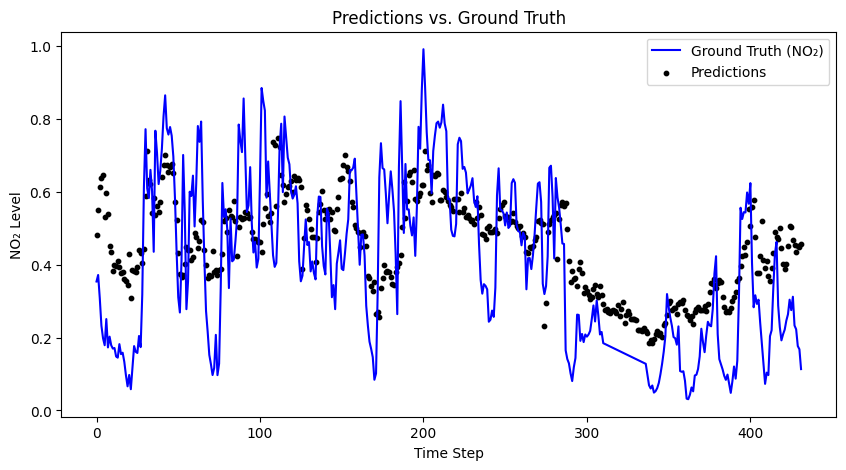

In [25]:
import torch
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
best_model.eval()

y_preds = []
y_trues = []

# Iterate through the test set and collect predictions & ground truth
with torch.no_grad():
    for batch in test_loader:
        x_test, y_true = batch  # Get input and ground truth
        x_test = x_test.to("cpu")  # Ensure data is on CPU if needed

        # Get predictions
        y_pred = best_model(x_test)

        # Store results
        y_preds.append(y_pred.cpu())
        y_trues.append(y_true.cpu())

# Convert lists to tensors
y_preds = torch.cat(y_preds, dim=0).numpy()
y_trues = torch.cat(y_trues, dim=0).numpy()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_trues.flatten(), label="Ground Truth (NO₂)", linestyle="-", color="blue")
plt.scatter(range(len(y_preds.flatten())), y_preds.flatten(), label="Predictions", color="black", s=10)

plt.xlabel("Time Step")
plt.ylabel("NO₂ Level")
plt.title("Predictions vs. Ground Truth")
plt.legend()
plt.show()
